In [26]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [27]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z', 1: 'z'}) -> QuantumCircuit:
    """For E91, we take state to be '00', '01', '10', '11' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(2)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[1] == '1':
        qc.x(1)
    
    # create the superposition
    qc.h(0)
    qc.cx(0,1)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [28]:
print(create_circuit('01',100).draw())

        ┌───┐     ┌────────────────┐ ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├─░─┤M├───
        ├───┤┌─┴─┐├────────────────┤ ░ └╥┘┌─┐
   q_1: ┤ X ├┤ X ├┤ Delay(100[ns]) ├─░──╫─┤M├
        └───┘└───┘└────────────────┘ ░  ║ └╥┘
meas: 2/════════════════════════════════╩══╩═
                                        0  1 


In [29]:
print(create_circuit('00',100,{0: 'z', 1: 'x'}).draw())

        ┌───┐     ┌────────────────┐      ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├──────░─┤M├───
        └───┘┌─┴─┐├────────────────┤┌───┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├┤ Delay(100[ns]) ├┤ H ├─░──╫─┤M├
             └───┘└────────────────┘└───┘ ░  ║ └╥┘
meas: 2/═════════════════════════════════════╩══╩═
                                             0  1 


In [30]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int,
               q2_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","sdg","id"])
        
        q2_len = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q2_gate_len)
        thermal_gate_2q = q2_len.tensor(q2_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_2q,"cx")
    
    return noise_model

In [31]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['x', 'id', 'h', 'sdg', 'delay', 'cx', 'measure']>

In [32]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['delay', 'measure']>

In [33]:
noise_params = {"T1":93400, "T2":116160} # ibmq_lima
q1_gate_len = 35.55 # 3.5555555555555554e-08
q2_gate_len = 305.77 # ibmq_lima
measure_len = 5351.11 # ibmq_lima

In [34]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for E91 protocol"""
    """Channel: 1 => |00>+|11>, 2 => |01>+|10>"""
    
    if channel == '1':
        state = '00'
    elif channel == '2':
        state = '01'
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,q2_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    
    success = 0
    
    if channel == '1':
        if '00' in counts.keys():
            success += counts['00']
        if '11' in counts.keys():
            success += counts['11']
    
    elif channel == '2':
        if '01' in counts.keys():
            success += counts['01']
        if '10' in counts.keys():
            success += counts['10']
            
    return float(success/shots)

In [37]:
run('1',1000,{"delay": True, "measure": False, "gate": False})

0.993

In [38]:
run('1',1000,{"delay": True, "measure": True, "gate": False})

0.943

In [39]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

0.944

# Only Delay

In [40]:
import matplotlib.pyplot as plt

listofSuccess1=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess1.append(success)
    

In [41]:
import numpy as np
delay = np.arange(0,1001000,1000)


In [42]:
from statistics import mean
a= listofSuccess1
print(*map(mean, zip(*a)))

1.0 0.9893 0.9792 0.9703499999999999 0.9618 0.9513999999999999 0.93945 0.9354 0.9244 0.9178000000000001 0.9076500000000001 0.90495 0.8949 0.88495 0.8771 0.87675 0.8648 0.86165 0.8586 0.8509 0.8417 0.8365 0.8366 0.8267 0.82475 0.81685 0.8147 0.80885 0.81175 0.8035 0.8035 0.79735 0.7961 0.7847500000000001 0.788 0.78505 0.7857500000000001 0.78295 0.7812 0.77525 0.7745 0.76995 0.7648 0.7635000000000001 0.767 0.7642 0.7619 0.76365 0.76 0.75575 0.7599 0.75485 0.7535000000000001 0.7547 0.75085 0.7513 0.749 0.7527 0.7499 0.74595 0.7539 0.75735 0.75315 0.7482 0.7521 0.74555 0.74735 0.75455 0.7491 0.7516 0.74715 0.7514 0.7486 0.75375 0.74935 0.74995 0.75115 0.75275 0.75695 0.7525 0.74825 0.75945 0.7568 0.75905 0.75625 0.7605500000000001 0.75795 0.7621 0.75905 0.7614 0.7654 0.76685 0.771 0.7674 0.7699 0.7667 0.7656000000000001 0.7712 0.7747 0.7766500000000001 0.77675 0.77595 0.7835000000000001 0.77975 0.7802 0.779 0.7855000000000001 0.7845 0.7873 0.7875 0.7896500000000001 0.7865 0.78825 0.79335 0

In [43]:
# 20 Times Average 
b=[1.0,0.9893,0.9792,0.9703499999999999,0.9618,0.9513999999999999,0.93945,0.9354,0.9244,0.9178000000000001,0.9076500000000001,0.90495,0.8949,0.88495,0.8771,0.87675,0.8648,0.86165,0.8586,0.8509,0.8417,0.8365,0.8366,0.8267,0.82475,0.81685,0.8147,0.80885,0.81175,0.8035,0.8035,0.79735,0.7961,0.7847500000000001,0.788,0.78505,0.7857500000000001,0.78295,0.7812,0.77525,0.7745,0.76995,0.7648,0.7635000000000001,0.767,0.7642,0.7619,0.76365,0.76,0.75575,0.7599,0.75485,0.7535000000000001,0.7547,0.75085,0.7513,0.749,0.7527,0.7499,0.74595,0.7539,0.75735,0.75315,0.7482,0.7521,0.74555,0.74735,0.75455,0.7491,0.7516,0.74715,0.7514,0.7486,0.75375,0.74935,0.74995,0.75115,0.75275,0.75695,0.7525,0.74825,0.75945,0.7568,0.75905,0.75625,0.7605500000000001,0.75795,0.7621,0.75905,0.7614,0.7654,0.76685,0.771,0.7674,0.7699,0.7667,0.7656000000000001,0.7712,0.7747,0.7766500000000001,0.77675,0.77595,0.7835000000000001,0.77975,0.7802,0.779,0.7855000000000001,0.7845,0.7873,0.7875,0.7896500000000001,0.7865,0.78825,0.79335,0.7896500000000001,0.7915500000000001,0.7963,0.7963,0.80245,0.7996000000000001,0.79735,0.8035,0.80935,0.8012,0.80585,0.8063,0.80455,0.81135,0.81155,0.80755,0.8155,0.8175,0.818,0.81375,0.81475,0.8253999999999999,0.82385,0.82135,0.8251,0.8264,0.8322999999999999,0.83315,0.83095,0.8333499999999999,0.8352499999999999,0.8303499999999999,0.83475,0.8361999999999999,0.8358,0.83755,0.84095,0.8444499999999999,0.84305,0.8448,0.84115,0.8441,0.84625,0.8463499999999999,0.85175,0.85275,0.84955,0.84955,0.85405,0.85615,0.8573,0.8597,0.854,0.85835,0.8638,0.8602,0.86195,0.86715,0.8676,0.87015,0.86885,0.8665,0.8724,0.8709,0.8713,0.875,0.8778,0.87435,0.8779,0.88195,0.8816,0.87845,0.8877,0.88635,0.8835,0.87985,0.8884,0.88925,0.8833,0.89175,0.89285,0.8932,0.88985,0.8935500000000001,0.89685,0.8939,0.8964,0.89915,0.89985,0.90025,0.8991,0.90495,0.8999,0.9016000000000001,0.90385,0.9018,0.9065000000000001,0.9052,0.9075500000000001,0.9077500000000001,0.9108,0.908,0.91125,0.9129,0.91585,0.91595,0.9091,0.91835,0.91635,0.91435,0.91735,0.92,0.9167000000000001,0.918,0.92,0.9207500000000001,0.9224,0.92645,0.92225,0.9242,0.9296,0.9259000000000001,0.9258500000000001,0.9273,0.9296500000000001,0.9265,0.92735,0.93425,0.93045,0.93,0.9291,0.9328000000000001,0.93095,0.93635,0.93705,0.93505,0.9382,0.93705,0.9374,0.93615,0.9380000000000001,0.9388,0.9371,0.9410499999999999,0.93665,0.94275,0.9402999999999999,0.9402,0.9438,0.9433,0.94505,0.94675,0.94705,0.9461999999999999,0.9483999999999999,0.9475,0.94685,0.9467,0.94775,0.9467,0.9481999999999999,0.9514499999999999,0.94865,0.9539,0.95105,0.9553499999999999,0.95385,0.9524999999999999,0.9522499999999999,0.95195,0.9563499999999999,0.9551,0.9549,0.9584499999999999,0.9562999999999999,0.9563999999999999,0.95855,0.9563499999999999,0.9566,0.95815,0.95955,0.9593499999999999,0.96,0.96065,0.9592499999999999,0.9633499999999999,0.95865,0.96065,0.9609,0.9614499999999999,0.9633499999999999,0.9613999999999999,0.96295,0.96315,0.9636,0.965,0.96655,0.96365,0.9683999999999999,0.96665,0.96655,0.966,0.9655,0.9663999999999999,0.9677,0.96985,0.96765,0.9679,0.9687,0.97055,0.969,0.9698,0.97115,0.9713999999999999,0.9699,0.9719,0.9713999999999999,0.9721,0.97285,0.97215,0.9747,0.97275,0.97385,0.9716,0.9744999999999999,0.97295,0.9744499999999999,0.9744999999999999,0.97395,0.97385,0.9746,0.9754499999999999,0.9744999999999999,0.97675,0.9751,0.9754499999999999,0.9773499999999999,0.97795,0.9772,0.9782,0.978,0.977,0.9766,0.97985,0.9793499999999999,0.9801,0.9803,0.9797,0.978,0.9793999999999999,0.9793999999999999,0.98115,0.98105,0.98155,0.9801,0.9815,0.9816,0.98175,0.9823,0.9828,0.98265,0.98225,0.983,0.9836,0.9823,0.9839,0.98135,0.9829,0.98385,0.9833,0.9837,0.9836,0.98465,0.9861,0.9852,0.9849,0.98525,0.9856,0.98495,0.987,0.9851,0.98535,0.98665,0.98755,0.9863999999999999,0.98725,0.9863999999999999,0.9867,0.9868,0.9878,0.9871,0.98815,0.9873999999999999,0.9877,0.9876,0.9876,0.98785,0.9897,0.9884999999999999,0.98915,0.98935,0.9875,0.9889,0.9886,0.9889,0.9891,0.9883,0.9884,0.9893,0.99065,0.9881,0.98985,0.99055,0.9901,0.9908,0.9901,0.9894499999999999,0.9909,0.99065,0.99025,0.99085,0.99105,0.9906,0.9912,0.9908,0.9904499999999999,0.9924,0.9908,0.9907,0.99015,0.9911,0.9914499999999999,0.99115,0.9924499999999999,0.99205,0.99225,0.9923,0.99175,0.9923,0.9913,0.9924,0.99285,0.992,0.99185,0.9924999999999999,0.9927,0.9914,0.99385,0.9928,0.99295,0.99295,0.99265,0.9936,0.99275,0.99275,0.9933,0.99325,0.99385,0.9941,0.9939,0.99435,0.99445,0.9942,0.99405,0.9938,0.9944999999999999,0.99435,0.9941,0.99365,0.99475,0.99445,0.99505,0.99425,0.99505,0.99465,0.9947,0.9949,0.9949,0.9947,0.9954,0.99525,0.99535,0.9944,0.9952,0.99645,0.9944999999999999,0.9961,0.9956,0.996,0.99515,0.99525,0.9958,0.9955,0.9951,0.9952,0.9956,0.99585,0.9947,0.99585,0.9969,0.99645,0.9955,0.9961,0.99585,0.99635,0.9968,0.9966,0.9952,0.9952,0.9964999999999999,0.9966,0.9964,0.99555,0.996,0.9966,0.9961,0.9969,0.9963,0.99635,0.99715,0.99685,0.99615,0.997,0.9971,0.99665,0.9967,0.9958,0.99725,0.9969,0.99725,0.99715,0.9969,0.9967,0.9971,0.99685,0.9975,0.99685,0.99745,0.99645,0.99745,0.99675,0.9977,0.99765,0.9972,0.99725,0.997,0.99775,0.99755,0.9978,0.99765,0.99785,0.99745,0.99655,0.9968,0.99725,0.9976,0.99795,0.9984999999999999,0.99755,0.99795,0.9983,0.9981,0.9981,0.9982,0.99765,0.99775,0.99775,0.9972,0.99885,0.9983,0.99815,0.99765,0.9986,0.9986,0.99905,0.99815,0.9977,0.99835,0.9981,0.9982,0.9982,0.99895,0.99875,0.9984999999999999,0.9982,0.99855,0.99825,0.99845,0.99855,0.99855,0.9984999999999999,0.99895,0.99875,0.99855,0.9982,0.99875,0.9986,0.9984,0.9984,0.9984,0.99865,0.99895,0.99845,0.99845,0.99855,0.99915,0.9984999999999999,0.9988,0.99855,0.9988,0.9989,0.99865,0.99915,0.99885,0.9988,0.9988,0.9991,0.99875,0.99895,0.9993,0.999,0.9988,0.99875,0.99925,0.9986,0.99885,0.9987,0.9993,0.99915,0.9989,0.99915,0.99895,0.9989,0.99915,0.99925,0.99885,0.99905,0.99865,0.9989,0.99885,0.99895,0.9994,0.9994,0.9993,0.99925,0.99945,0.9992,0.999,0.9993,0.99865,0.99895,0.9993,0.99945,0.99945,0.99935,0.99905,0.999,0.9994,0.99945,0.9993,0.9986,0.99915,0.9994,0.9992,0.9994,0.99935,0.9995,0.999,0.99935,0.99945,0.9994,0.9994,0.99945,0.9991,0.99945,0.9991,0.9994,0.99955,0.99945,0.99945,0.99955,0.99955,0.99955,0.99955,0.9993,0.9994,0.99955,0.99935,0.99975,0.99925,0.99935,0.99965,0.9995,0.99975,0.9994,0.9998,0.9993,0.9997,0.99945,0.9994,0.9997,0.9994,0.9996,0.9998,0.99975,0.9998,0.9995,0.99965,0.9996,0.99955,0.99955,0.9998,0.99955,0.99985,0.99965,0.9996,0.99945,0.9997,0.99955,0.9994,0.9997,0.99935,0.9995,0.99955,0.99975,0.9997,0.99975,0.9994,0.99955,0.9995,0.99985,0.99975,0.99975,0.99965,0.9998,0.9997,0.9998,0.9996,0.99965,0.99965,0.99985,0.9997,0.9998,0.99965,0.99955,0.9997,0.9998,0.99955,0.99965,0.9994,0.9997,0.9998,0.9998,0.9997,0.99975,0.99975,0.99975,0.9997,0.9998,0.9999,0.9997,0.99985,0.99965,0.99975,0.9997,0.99975,0.99985,0.99975,0.9998,0.9998,0.99985,0.9999,0.99985,0.9998,0.9998,0.9998,0.9995,0.99975,0.99975,0.9999,0.9997,0.99985,0.99975,0.99965,0.9998,0.9996,0.9998,0.9998,0.99975,0.99975,0.9998,0.99995,0.99985,0.9997,0.9999,0.99985,0.99985,0.9997,0.99995,0.9999,0.9999,0.9999,0.9999,0.99985,0.9997,0.9999,0.99985,0.9998,0.99995,0.99985,0.99985,0.99995,0.9998,0.9997,0.9999,0.99985,0.9999,0.9997,0.99995,0.9998,0.9999,0.99985,0.99995,0.99995,0.99985,0.99975,0.99985,0.99985,0.99995,0.99975,0.99995,0.9999,0.9999,0.9998,0.99985,0.9999,1.0,0.9999,0.99995,0.9999,0.9999,0.9999,1.0,0.99995,1.0,0.9999,0.9998,1.0,0.99995,0.9999,0.99985,0.99995,0.99995,1.0,0.99985,0.9999,0.99985,0.99995,0.9999,0.9999,0.99975,0.99985,0.99985,0.9999,0.9999,0.9999,0.99995,0.9999,1.0,0.9998,0.99995,1.0,0.99995,0.99995,0.9998,0.99995,1.0,0.99995,0.99995,1.0,0.9999,0.99985,0.99995,0.99995,0.99995,0.9999,0.99985,0.99995,0.99995,0.99995,0.99995,1.0,0.99975,1.0,0.99995,0.99995,1.0,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,0.99995,1.0,1.0,0.99985,0.99995,0.99995,0.9999,0.9999,0.99995,0.99995,0.9999,1.0,0.9999,1.0,0.9999,0.99995,0.9999,0.99995,1.0,0.9999,1.0,0.9999,0.9999,1.0,1.0,0.99995,0.99995,0.99995,1.0,0.99995,0.99995,0.99995,1.0,0.99995,0.99995,1.0,0.99995,0.99995,0.99995,0.9999,0.99995,1.0,0.9999,1.0,0.99995,0.99995,0.99995,0.99995,0.9999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99995,0.99995,1.0,1.0,1.0,1.0,1.0,1.0,0.99995,1.0,0.99995,1.0,0.99995,0.9999,1.0,1.0,1.0,0.99995,1.0,1.0,0.9999,1.0,0.99995,0.99995,0.99995,0.99995]


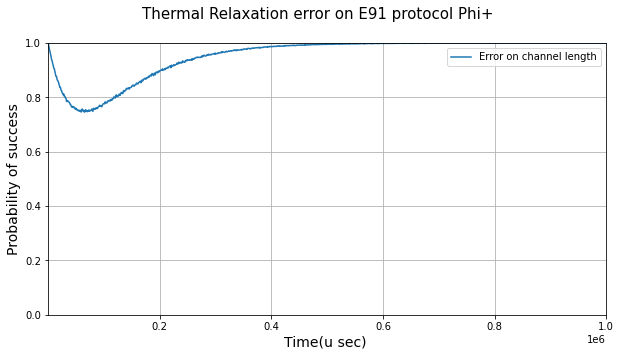

<Figure size 576x360 with 0 Axes>

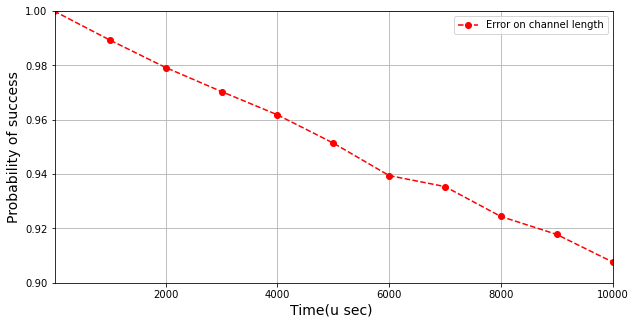

<Figure size 576x360 with 0 Axes>

In [45]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,b,label = "Error on channel length")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,b,'ro--',label = "Error on channel length")
ax.legend()

In [46]:
listofSuccess2=[]
for z in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    listofSuccess2.append(success)


In [47]:
from statistics import mean
a= listofSuccess2
print(*map(mean, zip(*a)))

1.0 0.99005 0.9803999999999999 0.9683499999999999 0.95855 0.9452499999999999 0.9354 0.92635 0.9166500000000001 0.9069 0.9015500000000001 0.8901 0.8784 0.87425 0.86315 0.8548 0.8481 0.8314499999999999 0.82675 0.8159 0.80755 0.7988500000000001 0.7901 0.77785 0.7736000000000001 0.7628 0.754 0.7523 0.73835 0.72675 0.72065 0.719 0.7061499999999999 0.70765 0.69695 0.68775 0.6758000000000001 0.6703 0.6685 0.65335 0.6461 0.6448 0.6335 0.63275 0.6254 0.6204 0.60935 0.60755 0.5986 0.59265 0.58375 0.58105 0.5740999999999999 0.56835 0.55635 0.55545 0.5492 0.53945 0.5406000000000001 0.53395 0.5251 0.51495 0.5134 0.51115 0.49815 0.4886 0.4911 0.48685 0.47835 0.4753 0.4768 0.46785 0.4657 0.4498 0.45185000000000003 0.45255 0.44505 0.43655 0.4351 0.4273 0.4185 0.4208 0.4089 0.4158 0.39575 0.40305 0.39525 0.3991 0.39225 0.3859 0.3782 0.37725000000000003 0.369 0.37015 0.3633 0.3638 0.35195 0.3535 0.3487 0.3472 0.3387 0.33515 0.32925 0.33125 0.32855 0.32145 0.3224 0.3205 0.3114 0.309 0.30835 0.3053 0.3009

In [48]:
# 20 Times Average 
b2=[1.0,0.99005,0.9803999999999999,0.9683499999999999,0.95855,0.9452499999999999,0.9354,0.92635,0.9166500000000001,0.9069,0.9015500000000001,0.8901,0.8784,0.87425,0.86315,0.8548,0.8481,0.8314499999999999,0.82675,0.8159,0.80755,0.7988500000000001,0.7901,0.77785,0.7736000000000001,0.7628,0.754,0.7523,0.73835,0.72675,0.72065,0.719,0.7061499999999999,0.70765,0.69695,0.68775,0.6758000000000001,0.6703,0.6685,0.65335,0.6461,0.6448,0.6335,0.63275,0.6254,0.6204,0.60935,0.60755,0.5986,0.59265,0.58375,0.58105,0.5740999999999999,0.56835,0.55635,0.55545,0.5492,0.53945,0.5406000000000001,0.53395,0.5251,0.51495,0.5134,0.51115,0.49815,0.4886,0.4911,0.48685,0.47835,0.4753,0.4768,0.46785,0.4657,0.4498,0.45185000000000003,0.45255,0.44505,0.43655,0.4351,0.4273,0.4185,0.4208,0.4089,0.4158,0.39575,0.40305,0.39525,0.3991,0.39225,0.3859,0.3782,0.37725000000000003,0.369,0.37015,0.3633,0.3638,0.35195,0.3535,0.3487,0.3472,0.3387,0.33515,0.32925,0.33125,0.32855,0.32145,0.3224,0.3205,0.3114,0.309,0.30835,0.3053,0.30095,0.29955,0.2918,0.28515,0.2889,0.2791,0.28445,0.2773,0.2818,0.2725,0.26555,0.26915,0.26405,0.2671,0.2565,0.25575000000000003,0.2552,0.24975,0.24760000000000001,0.2445,0.24355,0.24375,0.2323,0.23565,0.23365,0.2322,0.2272,0.2264,0.2221,0.21995,0.2182,0.21925,0.21315,0.2123,0.21045,0.2087,0.2074,0.19855,0.2007,0.1994,0.19870000000000002,0.1912,0.18985,0.19515,0.1876,0.1852,0.1853,0.18245,0.1826,0.17975,0.1734,0.17635,0.1731,0.17155,0.16775,0.16655,0.166,0.16015000000000001,0.16095,0.15805,0.1585,0.1536,0.15525,0.1568,0.14705000000000001,0.15475,0.15075,0.14755,0.14595,0.14175,0.1413,0.13905,0.1439,0.13705,0.13924999999999998,0.13195,0.1354,0.1331,0.1302,0.12815000000000001,0.12785,0.12715,0.1246,0.12155,0.12480000000000001,0.11965,0.1186,0.11615,0.11865,0.11685,0.1155,0.1165,0.11135,0.11225,0.1106,0.11425,0.11015,0.10755,0.1062,0.10005,0.1013,0.10145,0.10265,0.098,0.1002,0.09325,0.09535,0.09835,0.09745,0.09005,0.09345,0.09185,0.088,0.08945,0.08955,0.0863,0.08655,0.08535,0.0865,0.08455,0.08375,0.0829,0.08125,0.0807,0.07815,0.0767,0.0814,0.0796,0.07115,0.0765,0.0786,0.0738,0.07225,0.0701,0.07135,0.07115,0.0693,0.0717,0.06675,0.0669,0.06565,0.0697,0.06675,0.06625,0.0649,0.06365,0.06575,0.0593,0.0612,0.05975,0.0592,0.05975,0.05925,0.0594,0.0571,0.0575,0.05885,0.0544,0.0567,0.05375,0.0564,0.05315,0.055,0.05315,0.05195,0.05175,0.05105,0.05185,0.0503,0.0511,0.04815,0.04935,0.0445,0.04665,0.04415,0.0468,0.0455,0.04835,0.0466,0.0432,0.04455,0.04135,0.04295,0.04085,0.0429,0.04245,0.04125,0.04085,0.04035,0.03935,0.04075,0.03895,0.0382,0.03795,0.03845,0.0354,0.03735,0.035,0.0366,0.03795,0.03425,0.0354,0.0352,0.03305,0.032600000000000004,0.0336,0.0325,0.03145,0.03175,0.0319,0.03225,0.03085,0.0304,0.0305,0.03175,0.02885,0.031100000000000003,0.0306,0.02975,0.0285,0.02915,0.02955,0.02875,0.0279,0.0279,0.02735,0.02995,0.02675,0.02415,0.0276,0.0257,0.02515,0.02475,0.0245,0.0239,0.023200000000000002,0.023,0.02525,0.02175,0.021500000000000002,0.02395,0.0238,0.02175,0.0239,0.0215,0.0214,0.01965,0.02165,0.0205,0.02185,0.02015,0.0202,0.02185,0.021,0.01875,0.0181,0.01905,0.01855,0.0178,0.019,0.0201,0.0188,0.01895,0.01595,0.01815,0.01805,0.01855,0.0176,0.01745,0.0171,0.0181,0.01605,0.01565,0.01505,0.018,0.01675,0.0159,0.01515,0.01465,0.01515,0.01385,0.01645,0.01535,0.01445,0.0143,0.01595,0.01385,0.01405,0.01405,0.01285,0.01335,0.01355,0.0129,0.0134,0.01425,0.0142,0.013900000000000001,0.0124,0.01125,0.01145,0.0112,0.01125,0.01135,0.0117,0.0127,0.0112,0.01235,0.01015,0.0094,0.01045,0.0109,0.01105,0.011049999999999999,0.00925,0.01055,0.00925,0.0096,0.0094,0.0094,0.011049999999999999,0.0107,0.009049999999999999,0.01105,0.0092,0.008749999999999999,0.00895,0.00825,0.0094,0.0092,0.0084,0.00855,0.0092,0.008150000000000001,0.00835,0.00935,0.0079,0.00955,0.0088,0.0079,0.00835,0.008,0.0088,0.007,0.00735,0.0074,0.0074,0.0085,0.0076,0.0071,0.00815,0.00665,0.00655,0.008,0.00715,0.0067,0.0068,0.0062,0.0069,0.00685,0.00595,0.00725,0.0066,0.0066,0.00625,0.0056,0.0051,0.0057,0.0057,0.00615,0.00585,0.0057,0.00515,0.0049,0.0046500000000000005,0.0048000000000000004,0.0062,0.00495,0.00455,0.0048000000000000004,0.0038,0.0051,0.0044,0.0051,0.00485,0.00385,0.00505,0.0051,0.0046500000000000005,0.0046500000000000005,0.0046,0.0048000000000000004,0.0039000000000000003,0.00435,0.00555,0.0043,0.00475,0.00415,0.00485,0.004,0.0044,0.0041,0.00385,0.0046,0.0043,0.0044,0.00495,0.0034000000000000002,0.00415,0.00365,0.00355,0.00335,0.0032,0.00295,0.0037,0.004,0.0031,0.00375,0.00365,0.004,0.0039,0.00295,0.00345,0.0029000000000000002,0.0028,0.00295,0.00375,0.00295,0.00255,0.00245,0.00245,0.00335,0.0037,0.0034000000000000002,0.0032,0.002,0.0032,0.0021,0.00215,0.00295,0.0028,0.0028,0.0025,0.0023,0.00255,0.00315,0.0028,0.0019,0.0025,0.0025,0.0031,0.00255,0.0035,0.00185,0.0029000000000000002,0.0022,0.0024000000000000002,0.0021,0.0022,0.00345,0.00235,0.002,0.0022500000000000003,0.00155,0.0019500000000000001,0.0027,0.0019,0.0018,0.0018,0.00185,0.00205,0.00205,0.0014,0.0019,0.0022,0.0014,0.00185,0.0017000000000000001,0.00125,0.0015,0.00185,0.002,0.00255,0.00175,0.0015,0.0016,0.002,0.00165,0.0018,0.0013,0.0016,0.00135,0.00155,0.0017000000000000001,0.00205,0.00095,0.00155,0.00115,0.00155,0.001,0.0011,0.0014,0.0016,0.00155,0.0009,0.001,0.001,0.0014,0.0014500000000000001,0.0011,0.00135,0.00125,0.0014500000000000001,0.0014500000000000001,0.00105,0.00165,0.00105,0.00115,0.00065,0.00105,0.0011,0.0015,0.0012000000000000001,0.0012000000000000001,0.001,0.0006000000000000001,0.00115,0.001,0.00115,0.00115,0.0009,0.00065,0.00075,0.0008500000000000001,0.00105,0.00105,0.0008,0.00075,0.0009,0.00105,0.00075,0.00075,0.00095,0.001,0.00105,0.0007,0.0008500000000000001,0.00065,0.00095,0.0009,0.00045,0.0009,0.00055,0.00065,0.0008500000000000001,0.001,0.0008500000000000001,0.0012000000000000001,0.0007,0.0007,0.00105,0.001,0.00065,0.0009,0.0005,0.0009,0.0006000000000000001,0.00065,0.00075,0.0008500000000000001,0.00095,0.00065,0.0008500000000000001,0.00030000000000000003,0.00065,0.0006000000000000001,0.00055,0.0004,0.00075,0.0005,0.0006000000000000001,0.0009,0.0005,0.0005,0.00055,0.00065,0.00035,0.00045,0.0006000000000000001,0.001,0.0005,0.00025,0.00035,0.00055,0.00035,0.00055,0.0007,0.00065,0.00035,0.00030000000000000003,0.00030000000000000003,0.00065,0.00045,0.0007,0.0004,0.00055,0.0001,0.00035,0.0006000000000000001,0.0007,0.0001,0.00065,0.0006000000000000001,0.00030000000000000003,0.00035,0.00030000000000000003,0.00055,0.00025,0.00035,0.0005,0.00030000000000000003,0.00025,0.00055,0.00030000000000000003,0.0004,0.00035,0.0004,0.0004,0.0004,0.00045,0.00055,0.00035,0.00030000000000000003,0.00030000000000000003,0.0002,0.00035,0.0004,0.0004,0.00030000000000000003,0.00025,0.0001,0.0004,0.00035,0.0002,0.00025,0.00015000000000000001,0.0002,0.00025,0.0002,0.00015000000000000001,0.00025,0.0002,0.00030000000000000003,0.00045,0.0001,0.0002,0.0002,0.0002,0.0002,0.00015000000000000001,0.00035,0.00035,0.0002,0.00045,0.00015000000000000001,0.00025,0.00030000000000000003,5e-05,0.00035,0.0002,0.0002,0.00025,0.00015000000000000001,0.00025,0.00015000000000000001,0.00015000000000000001,0.00035,5e-05,0.0004,5e-05,0.0004,0.00025,0.00030000000000000003,0.0002,0.0001,0.00035,0.0002,0.00015000000000000001,0.0,0.0002,0.0001,0.0002,0.00015000000000000001,0.00030000000000000003,0.0,0.0,0.0002,0.0001,0.0002,0.00030000000000000003,0.00015000000000000001,0.00025,0.00015000000000000001,0.00025,5e-05,0.00015000000000000001,0.0002,0.00015000000000000001,0.00015000000000000001,0.00025,0.00025,0.0001,0.0005,5e-05,0.0001,5e-05,0.00015000000000000001,5e-05,0.00025,0.0001,5e-05,0.00015000000000000001,5e-05,0.00030000000000000003,0.00015000000000000001,5e-05,0.00015000000000000001,5e-05,0.0002,5e-05,5e-05,5e-05,0.0002,0.0001,0.0002,5e-05,0.0004,0.00030000000000000003,0.00025,5e-05,0.0002,5e-05,0.0,0.00015000000000000001,0.0001,5e-05,0.00015000000000000001,0.0001,0.00035,5e-05,5e-05,0.00015000000000000001,5e-05,0.0001,0.0001,0.0001,0.00015000000000000001,0.0,0.00015000000000000001,0.0,0.0001,0.0001,0.0002,5e-05,0.0,5e-05,0.00015000000000000001,0.0,0.00015000000000000001,0.0001,5e-05,0.00015000000000000001,0.0,5e-05,0.0002,0.0,0.00015000000000000001,0.0001,5e-05,5e-05,5e-05,0.0,0.0001,0.0,0.0,0.0001,5e-05,0.0002,0.0,0.0001,5e-05,0.0,0.0002,0.0001,5e-05,5e-05,0.0,0.0001,5e-05,0.0,5e-05,0.00015000000000000001,5e-05,5e-05,0.00030000000000000003,0.0,5e-05,0.0,0.0,0.0001,0.0,5e-05,5e-05,5e-05,0.0,5e-05,5e-05,0.0001,5e-05,0.0001,0.0,0.00015000000000000001,0.0,0.0,5e-05,5e-05,0.0,5e-05,0.00015000000000000001,0.0,0.0001,0.0002,0.0,5e-05,0.0001,0.0001,0.0,5e-05,0.0001,0.0,0.0,5e-05,5e-05,5e-05,0.0,0.0,5e-05,5e-05,0.0,0.0,5e-05,0.0,5e-05,0.0,5e-05,5e-05,0.0,0.0,5e-05,0.0,0.0,0.0,5e-05,0.0001,5e-05,0.0,5e-05,5e-05,5e-05,0.0,0.0,5e-05,5e-05,5e-05,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,5e-05,0.0]


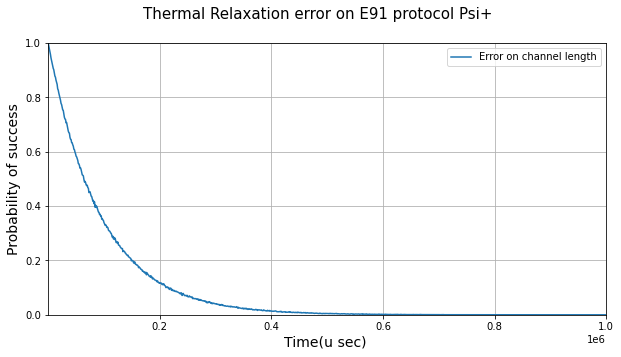

<Figure size 576x360 with 0 Axes>

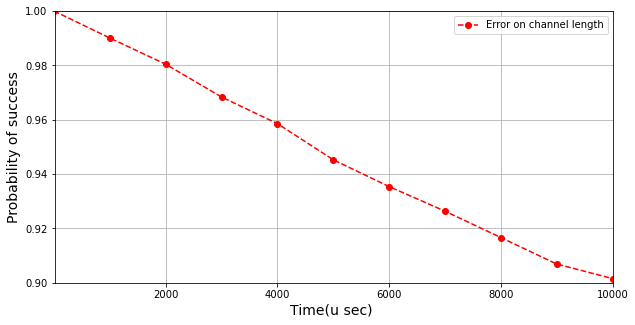

<Figure size 576x360 with 0 Axes>

In [49]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,b2,label = "Error on channel length")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,b2,'ro--',label = "Error on channel length")
ax.legend()

# Delay and Measure

In [50]:
import matplotlib.pyplot as plt

listofSuccess_DandM=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DandM.append(success)
    

In [51]:
from statistics import mean
a= listofSuccess_DandM
print(*map(mean, zip(*a)))

0.95005 0.93995 0.9318500000000001 0.9247500000000001 0.9135500000000001 0.90705 0.89715 0.88995 0.8865500000000001 0.8791 0.86725 0.86565 0.8631 0.8545 0.84275 0.8481 0.8412499999999999 0.8334999999999999 0.8273499999999999 0.8251499999999999 0.82145 0.8148 0.80395 0.80725 0.8018500000000001 0.7977500000000001 0.7978500000000001 0.7954 0.79205 0.7889 0.78125 0.77945 0.78115 0.7736500000000001 0.77815 0.76665 0.77005 0.7714 0.7711 0.76715 0.75825 0.76065 0.75785 0.75805 0.7647 0.75605 0.7473 0.7548 0.75595 0.75325 0.74915 0.7472 0.75095 0.75435 0.75205 0.7518 0.74765 0.7507 0.744 0.7538 0.7501 0.7533 0.7509 0.7488 0.7486 0.75455 0.7545 0.75185 0.7607 0.7508 0.7529 0.7577 0.75295 0.7568 0.75445 0.7578 0.76025 0.75685 0.75905 0.7591 0.75975 0.76275 0.76425 0.76695 0.76505 0.7643 0.76395 0.76495 0.76895 0.7677 0.76905 0.76695 0.7733 0.7708 0.77035 0.7748 0.7778 0.77805 0.7794 0.7803 0.7824 0.78035 0.7798 0.7875500000000001 0.7905500000000001 0.79015 0.7913 0.7895000000000001 0.79165000000

In [52]:
c= [0.95005,0.93995,0.9318500000000001,0.9247500000000001,0.9135500000000001,0.90705,0.89715,0.88995,0.8865500000000001,0.8791,0.86725,0.86565,0.8631,0.8545,0.84275,0.8481,0.8412499999999999,0.8334999999999999,0.8273499999999999,0.8251499999999999,0.82145,0.8148,0.80395,0.80725,0.8018500000000001,0.7977500000000001,0.7978500000000001,0.7954,0.79205,0.7889,0.78125,0.77945,0.78115,0.7736500000000001,0.77815,0.76665,0.77005,0.7714,0.7711,0.76715,0.75825,0.76065,0.75785,0.75805,0.7647,0.75605,0.7473,0.7548,0.75595,0.75325,0.74915,0.7472,0.75095,0.75435,0.75205,0.7518,0.74765,0.7507,0.744,0.7538,0.7501,0.7533,0.7509,0.7488,0.7486,0.75455,0.7545,0.75185,0.7607,0.7508,0.7529,0.7577,0.75295,0.7568,0.75445,0.7578,0.76025,0.75685,0.75905,0.7591,0.75975,0.76275,0.76425,0.76695,0.76505,0.7643,0.76395,0.76495,0.76895,0.7677,0.76905,0.76695,0.7733,0.7708,0.77035,0.7748,0.7778,0.77805,0.7794,0.7803,0.7824,0.78035,0.7798,0.7875500000000001,0.7905500000000001,0.79015,0.7913,0.7895000000000001,0.7916500000000001,0.7896000000000001,0.79205,0.79415,0.7965500000000001,0.80055,0.7956000000000001,0.7996500000000001,0.8006500000000001,0.802,0.8019000000000001,0.80555,0.80405,0.80845,0.80995,0.8162,0.8168,0.81315,0.81045,0.8140499999999999,0.8195,0.8195,0.8161,0.8269,0.823,0.827,0.8239,0.82705,0.8235,0.82875,0.8331999999999999,0.82905,0.83195,0.8364499999999999,0.84065,0.8381,0.8402499999999999,0.8432499999999999,0.83895,0.8444499999999999,0.8452999999999999,0.84825,0.844,0.8473999999999999,0.85115,0.85225,0.8548,0.85215,0.85775,0.84865,0.8609,0.8588,0.86075,0.86055,0.86365,0.8609,0.86475,0.8644,0.86515,0.8632,0.8651,0.8689,0.87065,0.8733,0.87465,0.8742,0.8744,0.87485,0.8761,0.88135,0.88035,0.8806,0.87965,0.8817,0.8867,0.88545,0.88575,0.8937,0.8838,0.8865000000000001,0.88815,0.8907,0.89285,0.8904,0.8905500000000001,0.89145,0.8926000000000001,0.8934,0.9,0.89745,0.8984,0.9011,0.9027000000000001,0.9003,0.90145,0.90515,0.9041,0.90495,0.90605,0.9085500000000001,0.9087000000000001,0.9069,0.9088,0.90835,0.9135,0.91215,0.91745,0.9125500000000001,0.91495,0.91595,0.9123,0.9159,0.9195500000000001,0.9234,0.9173,0.9199,0.9197000000000001,0.92035,0.91825,0.9213,0.92765,0.9277000000000001,0.9257000000000001,0.9256500000000001,0.9245,0.92955,0.9314,0.9309000000000001,0.93025,0.9307000000000001,0.9297500000000001,0.9297500000000001,0.9342,0.9339000000000001,0.9348000000000001,0.9380000000000001,0.9362,0.9346,0.93555,0.93825,0.9376,0.9391,0.93715,0.9396,0.9427,0.9422,0.9441999999999999,0.94405,0.9394,0.9453499999999999,0.94395,0.9456,0.94605,0.9467,0.9459,0.94685,0.94505,0.94855,0.94785,0.9489,0.951,0.94905,0.9504999999999999,0.9503999999999999,0.9513999999999999,0.9504999999999999,0.9535,0.9531499999999999,0.954,0.9516,0.9522999999999999,0.95395,0.95595,0.95255,0.9569,0.9594499999999999,0.9587,0.9562999999999999,0.95955,0.9561999999999999,0.95585,0.9601999999999999,0.9587,0.9588,0.95915,0.9608,0.9606,0.95995,0.96495,0.95965,0.9627,0.96395,0.9612499999999999,0.9642999999999999,0.9652999999999999,0.96405,0.96815,0.9662,0.9654499999999999,0.9652499999999999,0.9662499999999999,0.96705,0.9668,0.96865,0.96885,0.9681,0.9712,0.96715,0.96865,0.96985,0.9711,0.9703499999999999,0.969,0.9718,0.97065,0.9708,0.97165,0.9721,0.9712,0.9712,0.97205,0.97295,0.97295,0.9733499999999999,0.9744999999999999,0.97505,0.97595,0.9758,0.976,0.97215,0.97565,0.97715,0.9749,0.9769,0.9768,0.9763999999999999,0.977,0.9772,0.9771,0.97785,0.9794499999999999,0.97805,0.97815,0.9787,0.9797,0.9791,0.9793999999999999,0.9793499999999999,0.9794499999999999,0.9793999999999999,0.97905,0.97995,0.9803499999999999,0.97855,0.98165,0.98105,0.983,0.9806,0.97925,0.9814499999999999,0.9823999999999999,0.9832,0.9823,0.98175,0.98325,0.98175,0.9822,0.9843999999999999,0.98385,0.98375,0.9826,0.98415,0.985,0.9844499999999999,0.98425,0.9842,0.98435,0.9847,0.9844499999999999,0.98425,0.9859,0.98485,0.98725,0.98555,0.9875,0.98565,0.9862,0.9864999999999999,0.98595,0.98865,0.9877,0.98715,0.98755,0.98615,0.98675,0.9888,0.98675,0.98795,0.98685,0.98925,0.9874499999999999,0.98865,0.98855,0.9875,0.98915,0.98795,0.98865,0.9898,0.98995,0.9884,0.98975,0.9887,0.98965,0.99005,0.9895,0.9895,0.9904499999999999,0.98985,0.99025,0.99105,0.99035,0.9895,0.99105,0.99025,0.99005,0.9904,0.9913,0.991,0.9916,0.99055,0.9929,0.99205,0.99195,0.9926,0.9916,0.9919,0.99105,0.99185,0.9932,0.9912,0.9934,0.9929,0.99235,0.9929,0.99165,0.99225,0.9927,0.99205,0.99355,0.99295,0.9937,0.99325,0.9932,0.9934,0.99275,0.9933,0.9935,0.99375,0.9938,0.9932,0.9942,0.9939,0.9934499999999999,0.9936,0.9936,0.9941,0.9944,0.99385,0.99395,0.9946,0.99395,0.9942,0.99435,0.99455,0.99475,0.99465,0.99525,0.99485,0.9958,0.99405,0.99565,0.9946,0.9949,0.99555,0.9953,0.995,0.99415,0.99545,0.9952,0.99485,0.99485,0.99545,0.9957,0.996,0.9951,0.99565,0.99585,0.9954,0.99665,0.99535,0.9954,0.9962,0.99515,0.99585,0.99675,0.99655,0.9962,0.99665,0.9961,0.99565,0.99585,0.99585,0.996,0.99615,0.9968,0.9973,0.99685,0.9967,0.99675,0.99645,0.9969,0.9971,0.99705,0.99675,0.99725,0.99665,0.99685,0.9969,0.99665,0.9969,0.9977,0.99695,0.9968,0.9973,0.9975,0.9974,0.9969,0.99685,0.9969,0.9967,0.99745,0.9976,0.9969,0.99695,0.9977,0.99735,0.99715,0.997,0.99755,0.99755,0.99745,0.9983,0.99755,0.9982,0.99725,0.9977,0.99825,0.99705,0.9976,0.9981,0.99745,0.9972,0.99805,0.99805,0.99755,0.998,0.99805,0.99795,0.9981,0.99795,0.99805,0.99825,0.99805,0.99865,0.9982,0.99795,0.9986,0.9979,0.9986,0.9975,0.998,0.9987,0.99875,0.99825,0.99885,0.9983,0.9988,0.99815,0.99835,0.99845,0.9978,0.9986,0.99885,0.9988,0.99825,0.9987,0.99865,0.9987,0.99875,0.99855,0.9986,0.9989,0.99895,0.9988,0.99835,0.99885,0.99905,0.9986,0.99845,0.998,0.99845,0.99875,0.9989,0.9986,0.999,0.99895,0.999,0.99875,0.99875,0.99855,0.9991,0.9984999999999999,0.99875,0.9987,0.9988,0.9988,0.9989,0.9992,0.9991,0.99945,0.99925,0.99925,0.9991,0.9992,0.9992,0.999,0.999,0.99915,0.99875,0.99905,0.999,0.9993,0.9993,0.99885,0.99925,0.99925,0.9993,0.99945,0.999,0.9991,0.9994,0.9992,0.99905,0.9991,0.9993,0.9992,0.9993,0.99945,0.99905,0.99935,0.99925,0.99925,0.99955,0.99935,0.9997,0.9994,0.999,0.99935,0.99925,0.9994,0.99945,0.99935,0.99935,0.9991,0.9997,0.9995,0.9995,0.9991,0.9994,0.99915,0.9994,0.9996,0.99915,0.9992,0.99925,0.99925,0.9996,0.99905,0.9993,0.9994,0.9995,0.9994,0.9997,0.99975,0.99925,0.9996,0.9994,0.9995,0.99935,0.99955,0.99935,0.9993,0.9995,0.9995,0.99955,0.9996,0.99965,0.9997,0.99975,0.99965,0.9996,0.99955,0.99925,0.99935,0.99955,0.99955,0.99945,0.99965,0.99945,0.9998,0.99955,0.9996,0.99955,0.9997,0.9994,0.9996,0.99965,0.9997,0.99935,0.99975,0.9995,0.9998,0.99955,0.99955,0.9998,0.9996,0.9995,0.99965,0.99975,0.99975,0.9997,0.9995,0.99975,0.99975,0.99955,0.99965,0.9998,0.9996,0.99965,0.9997,0.9997,0.9998,0.99965,0.9997,0.9997,0.99965,0.99985,0.99965,0.99965,0.9996,0.99965,0.9997,0.9997,0.9997,0.99985,0.9997,0.99985,0.99975,0.99965,0.99975,0.9996,0.9996,0.99995,0.9997,0.9997,0.99975,0.99985,0.99985,0.99985,0.99985,0.9999,0.9999,0.99965,0.99965,0.99975,0.99985,0.9997,0.99985,0.99985,0.99975,0.9997,0.9998,0.9998,0.9998,0.9998,0.9999,0.9998,0.9999,0.9997,1.0,0.9999,0.99985,0.9997,0.99985,0.9998,0.9998,0.9998,0.9999,0.9998,0.9999,0.9997,0.9999,0.9999,0.9998,0.99975,0.99985,0.9999,0.9999,0.99985,0.9999,0.9998,0.9999,0.9998,0.9999,0.9998,1.0,0.9998,0.9999,0.9999,1.0,0.9998,0.99995,0.99995,0.9999,0.9999,0.99985,0.9998,0.9999,1.0,0.9999,0.99995,0.99995,0.9999,0.99985,0.9999,0.9999,0.9999,0.99995,0.99995,0.9999,0.99995,0.99985,1.0,0.99995,0.99995,0.99995,0.9999,0.9998,0.9999,0.99985,0.99995,1.0,0.9999,0.99995,0.9999,1.0,1.0,0.99995,0.99995,0.99995,1.0,0.99995,0.99995,0.9999,0.99995,0.99995,0.99995,0.9999,0.99995,0.99995,0.99985,0.99995,0.99995,1.0,0.9999,0.99995,0.9999,0.99995,1.0,0.99995,0.99995,1.0,1.0,0.99995,0.9998,0.9999,0.99985,0.9999,0.99995,1.0,1.0,0.99995,0.99995,0.9999,1.0,1.0,1.0,0.9999,1.0,0.99995,1.0,1.0,1.0,0.99995,0.99995,0.99995,0.99995,0.99995,1.0,1.0,1.0,1.0,1.0,1.0,0.99985,1.0,0.99995,1.0,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,0.99995,1.0,1.0,0.99995,1.0,0.99995,1.0,0.99995,1.0,1.0,0.99995,1.0,0.99995,1.0,0.9999,0.9999,0.9999,0.99995,0.9999,1.0,1.0,0.99995,1.0,0.99995,0.99995,1.0,0.99995,0.99995,0.99995,1.0,0.99995,1.0,1.0,0.99995,1.0,0.99995,0.99995,1.0,0.99995,1.0,0.99995,1.0,1.0,0.99995,1.0,0.99995,1.0,1.0,1.0,1.0,1.0,1.0,0.99995,0.99995,1.0,1.0,1.0,1.0]


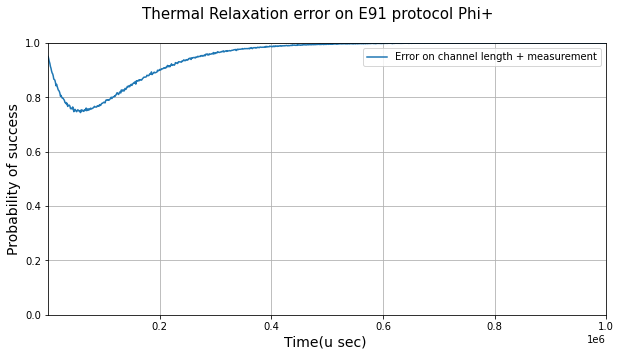

<Figure size 576x360 with 0 Axes>

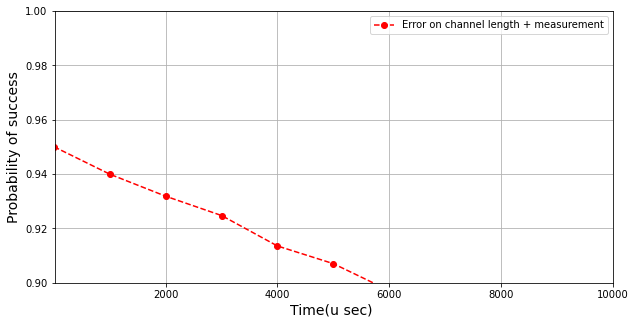

<Figure size 576x360 with 0 Axes>

In [54]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,c,label = "Error on channel length + measurement")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,c,'ro--',label = "Error on channel length + measurement")
ax.legend()

In [55]:
import matplotlib.pyplot as plt

listofSuccess_DandM2=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DandM2.append(success)
    

In [56]:
from statistics import mean
a= listofSuccess_DandM2
print(*map(mean, zip(*a)))

0.94505 0.9352 0.92515 0.9155500000000001 0.90245 0.89505 0.884 0.87645 0.87105 0.85405 0.8483499999999999 0.84255 0.83215 0.82035 0.8081 0.8037500000000001 0.79845 0.7936000000000001 0.7787000000000001 0.7702 0.7645 0.7584 0.74995 0.7389 0.73425 0.72505 0.712 0.7013499999999999 0.70095 0.68575 0.6844 0.6759000000000001 0.6706500000000001 0.66415 0.65245 0.6516000000000001 0.64725 0.6346 0.6268 0.63545 0.6151 0.6043 0.6034999999999999 0.5974999999999999 0.58895 0.584 0.5755 0.5712499999999999 0.56685 0.55965 0.5529000000000001 0.54735 0.54135 0.53785 0.5306500000000001 0.52275 0.5137 0.51285 0.49655 0.50215 0.4913 0.4885 0.4838 0.48345 0.47925 0.473 0.4638 0.46285 0.45445 0.451 0.446 0.43885 0.446 0.42995 0.4241 0.41935 0.4131 0.4134 0.4083 0.4068 0.40165 0.39465 0.39055 0.38935 0.3896 0.3777 0.37615 0.37224999999999997 0.36495 0.36075 0.36035 0.35105000000000003 0.3538 0.3507 0.3447 0.3417 0.34865 0.33255 0.3291 0.32615 0.3249 0.3146 0.3119 0.3157 0.30665 0.31155 0.3055 0.2971 0.2953 

In [57]:
c2=[0.94505,0.9352,0.92515,0.9155500000000001,0.90245,0.89505,0.884,0.87645,0.87105,0.85405,0.8483499999999999,0.84255,0.83215,0.82035,0.8081,0.8037500000000001,0.79845,0.7936000000000001,0.7787000000000001,0.7702,0.7645,0.7584,0.74995,0.7389,0.73425,0.72505,0.712,0.7013499999999999,0.70095,0.68575,0.6844,0.6759000000000001,0.6706500000000001,0.66415,0.65245,0.6516000000000001,0.64725,0.6346,0.6268,0.63545,0.6151,0.6043,0.6034999999999999,0.5974999999999999,0.58895,0.584,0.5755,0.5712499999999999,0.56685,0.55965,0.5529000000000001,0.54735,0.54135,0.53785,0.5306500000000001,0.52275,0.5137,0.51285,0.49655,0.50215,0.4913,0.4885,0.4838,0.48345,0.47925,0.473,0.4638,0.46285,0.45445,0.451,0.446,0.43885,0.446,0.42995,0.4241,0.41935,0.4131,0.4134,0.4083,0.4068,0.40165,0.39465,0.39055,0.38935,0.3896,0.3777,0.37615,0.37224999999999997,0.36495,0.36075,0.36035,0.35105000000000003,0.3538,0.3507,0.3447,0.3417,0.34865,0.33255,0.3291,0.32615,0.3249,0.3146,0.3119,0.3157,0.30665,0.31155,0.3055,0.2971,0.2953,0.28995,0.28875,0.29015,0.27795,0.29009999999999997,0.28045,0.2799,0.27625,0.26845,0.272,0.27265,0.26475,0.25735,0.2531,0.25165,0.2514,0.24845,0.2379,0.2427,0.23835,0.2336,0.2287,0.2298,0.22870000000000001,0.23145,0.2271,0.2244,0.2196,0.2169,0.21605,0.21605,0.2096,0.209,0.2091,0.19985,0.20600000000000002,0.19820000000000002,0.19625,0.1923,0.1876,0.18425,0.19045,0.19025,0.18485,0.18565,0.18265,0.17885,0.17355,0.1779,0.17565,0.1718,0.16945,0.16915,0.16655,0.17,0.16515,0.1608,0.1572,0.15815,0.1554,0.15545,0.15065,0.1487,0.1511,0.15305,0.1475,0.14725,0.14075,0.14075,0.14125000000000001,0.13585,0.1428,0.13235,0.1322,0.1315,0.1306,0.12825,0.13445000000000001,0.13015,0.12915,0.12605,0.12055,0.12255,0.1245,0.12015,0.12095,0.11575,0.11345,0.11515,0.11275,0.1109,0.10825,0.11165,0.10865,0.10735,0.10545,0.1072,0.10345,0.1,0.10135,0.0975,0.09885,0.10285,0.10005,0.09659999999999999,0.09475,0.0951,0.09435,0.09035,0.0897,0.08885,0.08925,0.08735,0.08975,0.0863,0.0842,0.0856,0.08374999999999999,0.0863,0.08015,0.07919999999999999,0.0808,0.0749,0.0795,0.0757,0.07844999999999999,0.0745,0.077,0.0758,0.0741,0.07255,0.0726,0.06955,0.0701,0.07115,0.07065,0.0645,0.06985,0.06775,0.06715,0.06605,0.0653,0.06655,0.0641,0.06265,0.060950000000000004,0.06165,0.0569,0.06195,0.05965,0.06,0.0618,0.057749999999999996,0.05405,0.05535,0.0552,0.05575,0.05635,0.05545,0.0536,0.0544,0.0495,0.0521,0.04835,0.0506,0.050749999999999997,0.0512,0.0493,0.04915,0.0479,0.048549999999999996,0.048799999999999996,0.0479,0.0474,0.0448,0.0449,0.049049999999999996,0.0464,0.0432,0.0426,0.0421,0.04,0.0438,0.04075,0.0408,0.038849999999999996,0.0403,0.03995,0.03965,0.03875,0.0419,0.0368,0.0375,0.0362,0.03595,0.03595,0.03615,0.0366,0.03605,0.03625,0.035,0.035750000000000004,0.0332,0.03275,0.03105,0.03235,0.0314,0.0309,0.0301,0.0322,0.03,0.0311,0.02965,0.0318,0.028650000000000002,0.03,0.0304,0.03145,0.0289,0.02825,0.027800000000000002,0.0287,0.0272,0.02675,0.02385,0.0263,0.025500000000000002,0.02435,0.02375,0.025750000000000002,0.02515,0.02585,0.02485,0.02315,0.02485,0.02275,0.02455,0.0233,0.0243,0.0217,0.02065,0.0245,0.02045,0.02145,0.02015,0.0225,0.02,0.02065,0.0203,0.0197,0.02015,0.0205,0.0191,0.02015,0.02,0.0201,0.0191,0.0187,0.0196,0.01735,0.0185,0.0183,0.0178,0.01655,0.0181,0.01585,0.01485,0.01625,0.01685,0.0155,0.0171,0.01495,0.0174,0.01635,0.017,0.01505,0.0153,0.015050000000000001,0.015,0.014199999999999999,0.0146,0.01385,0.0148,0.0133,0.01375,0.013,0.01365,0.01325,0.01295,0.01435,0.013,0.0121,0.0128,0.0124,0.01115,0.01375,0.012199999999999999,0.01145,0.01315,0.0116,0.01205,0.011899999999999999,0.01095,0.0096,0.01205,0.0122,0.0114,0.0097,0.0117,0.0117,0.01175,0.0104,0.01125,0.01,0.01115,0.01045,0.010199999999999999,0.0122,0.01005,0.0095,0.00875,0.0103,0.0098,0.0083,0.00775,0.009,0.0098,0.00895,0.0098,0.00835,0.008,0.008749999999999999,0.009,0.0086,0.00885,0.00845,0.00775,0.0083,0.00885,0.0076,0.00865,0.00775,0.0083,0.008,0.00805,0.00755,0.00725,0.007,0.00685,0.00685,0.00765,0.00705,0.00695,0.00585,0.0065,0.00715,0.0059,0.0061,0.00675,0.00675,0.00665,0.0068,0.00585,0.00595,0.006,0.00535,0.0052,0.00455,0.0054,0.00635,0.0061,0.0052,0.00545,0.0047,0.00575,0.0045,0.00485,0.0046500000000000005,0.0058,0.00565,0.0045000000000000005,0.00515,0.0047,0.0046,0.0042,0.00435,0.00585,0.0051,0.0043,0.00445,0.00505,0.0038,0.00445,0.0038,0.00365,0.0047,0.0036,0.00425,0.00495,0.0049,0.0032500000000000003,0.00395,0.0044,0.0039000000000000003,0.00375,0.00315,0.00375,0.00335,0.0036,0.00335,0.00405,0.00385,0.00305,0.0039,0.00345,0.0042,0.00285,0.0037,0.0033,0.0028,0.00385,0.0032500000000000003,0.00315,0.00305,0.0032,0.00305,0.0033,0.00295,0.00285,0.0034000000000000002,0.00295,0.003,0.00245,0.00305,0.0029,0.0025,0.00265,0.00245,0.00255,0.0021,0.0026,0.00215,0.003,0.0023,0.0021,0.00285,0.00205,0.0026,0.00235,0.00185,0.0025,0.0016,0.0026,0.0022500000000000003,0.0018,0.00175,0.0022,0.0022500000000000003,0.0023,0.00205,0.0025,0.00205,0.0023,0.0021,0.002,0.00235,0.00205,0.00205,0.0018,0.002,0.00185,0.002,0.0018,0.0014500000000000001,0.0014500000000000001,0.00155,0.0018,0.0017000000000000001,0.0014,0.0019500000000000001,0.0011,0.00165,0.00175,0.0022,0.0022,0.00215,0.0014,0.0019,0.0015,0.0014500000000000001,0.0016,0.00205,0.00165,0.0016,0.00165,0.0019,0.00115,0.0008500000000000001,0.0018,0.00135,0.0014,0.00095,0.00125,0.0009,0.00155,0.00155,0.0015,0.0015,0.0009,0.0015,0.0012000000000000001,0.0011,0.00105,0.00125,0.0013,0.0012000000000000001,0.00125,0.0012000000000000001,0.0008,0.00155,0.0009,0.0013,0.00095,0.00135,0.0008,0.0012000000000000001,0.0008500000000000001,0.00095,0.001,0.00115,0.0009,0.00135,0.00095,0.0013,0.0006000000000000001,0.0009,0.0008500000000000001,0.00095,0.0006000000000000001,0.0004,0.0009,0.00055,0.0008500000000000001,0.0008500000000000001,0.0008500000000000001,0.00075,0.00115,0.00105,0.00095,0.0008500000000000001,0.00075,0.00065,0.0008,0.0007,0.0008500000000000001,0.00065,0.00065,0.0008,0.0008,0.0005,0.0009,0.0007,0.00075,0.001,0.0008500000000000001,0.00075,0.00065,0.00075,0.00055,0.0009,0.00075,0.0005,0.0006000000000000001,0.0006000000000000001,0.0009,0.0006000000000000001,0.0007,0.00065,0.00045,0.0004,0.00045,0.0007,0.0007,0.00065,0.00045,0.0004,0.00035,0.00075,0.0005,0.00055,0.00035,0.0004,0.00045,0.0008,0.0005,0.0004,0.00030000000000000003,0.0006000000000000001,0.0006000000000000001,0.0005,0.00015000000000000001,0.00030000000000000003,0.00035,0.00055,0.0004,0.0005,0.0005,0.00075,0.00065,0.0004,0.00025,0.0002,0.0005,0.0009,0.0004,0.0001,0.00075,0.0004,0.00045,0.00015000000000000001,0.00045,0.00025,0.0002,0.0004,0.00035,0.0004,0.0004,0.0004,0.0005,0.00035,0.0005,0.00035,0.00025,0.00035,0.00030000000000000003,0.0002,0.00035,0.00015000000000000001,0.00035,0.00055,0.00035,0.0002,0.00030000000000000003,0.00030000000000000003,5e-05,0.00035,0.0002,0.0001,0.00030000000000000003,0.00025,0.00030000000000000003,0.00025,0.0001,0.00035,0.00030000000000000003,0.00030000000000000003,0.00030000000000000003,0.0002,0.00025,5e-05,0.0001,0.0002,0.00015000000000000001,0.00015000000000000001,0.00030000000000000003,0.0001,0.00025,0.0002,0.0002,0.00030000000000000003,0.0002,5e-05,0.00035,0.0002,0.00035,0.0001,0.0001,0.0002,0.00015000000000000001,0.00025,0.00015000000000000001,0.0001,0.00025,0.00015000000000000001,0.00025,0.00015000000000000001,0.0,5e-05,0.00030000000000000003,5e-05,0.00015000000000000001,0.0001,0.00015000000000000001,0.00030000000000000003,0.0001,0.0002,0.00015000000000000001,0.00025,0.0002,0.0004,0.00015000000000000001,0.00025,0.0001,5e-05,0.00015000000000000001,0.0002,0.0,0.00030000000000000003,0.0001,0.0002,0.0001,0.00015000000000000001,0.0002,0.0001,0.00015000000000000001,0.00030000000000000003,0.0001,0.00015000000000000001,0.00015000000000000001,0.00035,0.0002,0.00015000000000000001,5e-05,0.0001,0.0,0.0001,0.0001,0.00030000000000000003,0.00015000000000000001,0.0001,0.00030000000000000003,0.0001,0.0001,0.00015000000000000001,0.0,0.0001,5e-05,0.0001,0.0,0.0002,0.0,0.0001,0.0001,0.0002,0.00015000000000000001,0.0,0.0001,0.00015000000000000001,5e-05,0.0,5e-05,5e-05,0.0001,0.0,0.0001,0.00030000000000000003,5e-05,0.0001,0.0,0.0001,0.0001,0.0001,0.0002,0.0001,0.0,5e-05,0.0001,0.00015000000000000001,0.0001,0.0001,0.00015000000000000001,5e-05,5e-05,0.00025,0.0001,0.0002,0.0002,0.0001,0.00015000000000000001,0.0001,5e-05,0.0,5e-05,0.0001,5e-05,0.0001,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0001,0.00015000000000000001,0.0,0.0,5e-05,5e-05,0.0,0.0,0.0,5e-05,0.0001,0.0001,0.0001,0.0,5e-05,0.0001,0.0,0.0,5e-05,0.0,0.0,0.0,5e-05,0.00015000000000000001,0.0001,0.0,0.0,0.0,0.0001,0.0,0.0,5e-05,0.0,0.0,0.0001,0.0001,0.0001,5e-05,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,0.0,5e-05,5e-05,0.00015000000000000001,5e-05,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0001,0.0,5e-05,0.0,0.0002,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0001,0.0001,5e-05,0.0,0.0001,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.00015000000000000001]


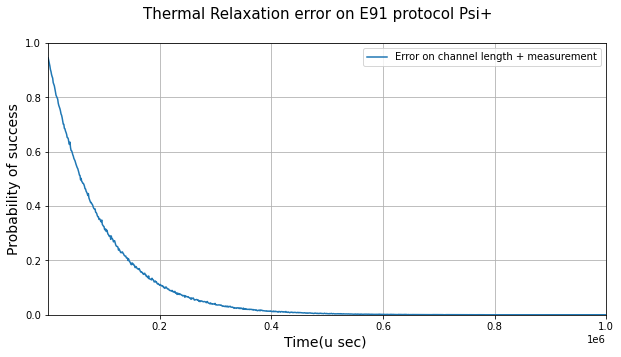

<Figure size 576x360 with 0 Axes>

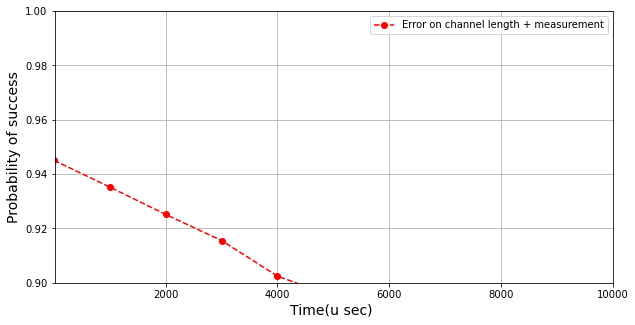

<Figure size 576x360 with 0 Axes>

In [58]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,c2,label = "Error on channel length + measurement")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,c2,'ro--',label = "Error on channel length + measurement")
ax.legend()

# Delay, Measure and Gate

In [59]:
import matplotlib.pyplot as plt

listofSuccess_DMG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DMG.append(success)
    

In [60]:
from statistics import mean
a= listofSuccess_DMG
print(*map(mean, zip(*a)))

0.9436 0.9357 0.9243 0.9213 0.9141 0.90345 0.8937 0.8941 0.8827 0.8765000000000001 0.86785 0.8674999999999999 0.85605 0.8531 0.84695 0.8416 0.8354999999999999 0.8332499999999999 0.8249 0.82035 0.81255 0.81425 0.8093 0.8043 0.8028500000000001 0.7967000000000001 0.79795 0.7895 0.78805 0.78385 0.78485 0.77735 0.78225 0.77675 0.7739 0.77015 0.77005 0.7634 0.7681 0.76625 0.7599 0.7659 0.7634 0.75555 0.7605500000000001 0.75965 0.7567 0.7582 0.75205 0.75615 0.7521 0.7507 0.74965 0.75385 0.74975 0.75 0.74865 0.74805 0.75175 0.74635 0.7496 0.74755 0.75035 0.74805 0.74925 0.74735 0.7466 0.7533 0.75075 0.74945 0.74605 0.75545 0.7527 0.75965 0.7554 0.7533 0.7602 0.7632 0.7621 0.7616 0.7632 0.76375 0.76235 0.75895 0.75875 0.7667 0.7624 0.7641 0.7685 0.77115 0.7698 0.76945 0.77015 0.7796000000000001 0.7736000000000001 0.775 0.7772 0.7798 0.7779 0.77475 0.77805 0.7819 0.7848 0.7901 0.7847000000000001 0.79205 0.78695 0.7914 0.78485 0.79495 0.7968000000000001 0.79315 0.7981 0.7913 0.80025 0.7982 0.7971

In [61]:
d=[0.9436,0.9357,0.9243,0.9213,0.9141,0.90345,0.8937,0.8941,0.8827,0.8765000000000001,0.86785,0.8674999999999999,0.85605,0.8531,0.84695,0.8416,0.8354999999999999,0.8332499999999999,0.8249,0.82035,0.81255,0.81425,0.8093,0.8043,0.8028500000000001,0.7967000000000001,0.79795,0.7895,0.78805,0.78385,0.78485,0.77735,0.78225,0.77675,0.7739,0.77015,0.77005,0.7634,0.7681,0.76625,0.7599,0.7659,0.7634,0.75555,0.7605500000000001,0.75965,0.7567,0.7582,0.75205,0.75615,0.7521,0.7507,0.74965,0.75385,0.74975,0.75,0.74865,0.74805,0.75175,0.74635,0.7496,0.74755,0.75035,0.74805,0.74925,0.74735,0.7466,0.7533,0.75075,0.74945,0.74605,0.75545,0.7527,0.75965,0.7554,0.7533,0.7602,0.7632,0.7621,0.7616,0.7632,0.76375,0.76235,0.75895,0.75875,0.7667,0.7624,0.7641,0.7685,0.77115,0.7698,0.76945,0.77015,0.7796000000000001,0.7736000000000001,0.775,0.7772,0.7798,0.7779,0.77475,0.77805,0.7819,0.7848,0.7901,0.7847000000000001,0.79205,0.78695,0.7914,0.78485,0.79495,0.7968000000000001,0.79315,0.7981,0.7913,0.80025,0.7982,0.79715,0.8047,0.8104,0.80645,0.8033,0.8095,0.8067,0.8114,0.8139,0.81995,0.8136,0.81735,0.8215,0.81495,0.8243499999999999,0.82075,0.827,0.8281499999999999,0.8264,0.8276,0.8267,0.8365,0.83565,0.8302499999999999,0.839,0.83085,0.8422499999999999,0.8327,0.83985,0.8442999999999999,0.8423499999999999,0.8431,0.8412,0.84255,0.8425,0.8467,0.8489,0.8507,0.85055,0.857,0.854,0.8586,0.85725,0.8597,0.86265,0.8604499999999999,0.8597,0.8584499999999999,0.86075,0.8661,0.87,0.86895,0.8702,0.86855,0.87235,0.87305,0.8772,0.87335,0.87525,0.8769,0.8792,0.87895,0.87995,0.87975,0.88315,0.88335,0.8887,0.8804,0.88605,0.88465,0.8884,0.887,0.8907,0.89315,0.8967,0.8879,0.8946000000000001,0.8975500000000001,0.89335,0.89545,0.9004,0.8976500000000001,0.90085,0.8982,0.9012,0.9011,0.90405,0.90195,0.9038,0.9051,0.9066000000000001,0.9067000000000001,0.9084,0.9094,0.9083,0.9091,0.913,0.9126000000000001,0.92015,0.9127500000000001,0.91245,0.9146500000000001,0.9182,0.9187000000000001,0.9203,0.9154,0.9181,0.92395,0.91705,0.92135,0.92405,0.9258500000000001,0.9266500000000001,0.92855,0.9252,0.9289000000000001,0.93115,0.92765,0.92705,0.93135,0.9338,0.93155,0.9329500000000001,0.9321,0.93165,0.93465,0.93455,0.9384,0.9370499999999999,0.93465,0.93575,0.9336,0.93725,0.93865,0.93745,0.93975,0.9406,0.94,0.94145,0.9450999999999999,0.94435,0.94505,0.9442999999999999,0.94485,0.94595,0.9467,0.9466,0.9460999999999999,0.94605,0.9493499999999999,0.9523499999999999,0.9513499999999999,0.9501999999999999,0.94885,0.95205,0.94955,0.95175,0.9537,0.95205,0.95205,0.9554499999999999,0.9524499999999999,0.95355,0.95575,0.9561499999999999,0.9564499999999999,0.95495,0.9579,0.95555,0.9581,0.9592499999999999,0.9593999999999999,0.9591999999999999,0.9591,0.9594499999999999,0.96015,0.9583499999999999,0.9593499999999999,0.9618,0.96205,0.9633499999999999,0.9609,0.9622499999999999,0.9624499999999999,0.9636,0.9647,0.963,0.9652499999999999,0.9652499999999999,0.9652499999999999,0.96805,0.9669,0.967,0.9653499999999999,0.96895,0.9663999999999999,0.96875,0.9681,0.96795,0.9679,0.9676,0.9678,0.9715,0.9712,0.9692999999999999,0.96975,0.97085,0.9716,0.9733999999999999,0.9727,0.97165,0.97185,0.9713499999999999,0.9728,0.9733999999999999,0.9724999999999999,0.9753499999999999,0.97405,0.9744499999999999,0.9732999999999999,0.9747,0.9746,0.97565,0.9753,0.977,0.9772,0.9773999999999999,0.9772,0.97655,0.9773499999999999,0.9763,0.9784999999999999,0.9763999999999999,0.975,0.97655,0.97725,0.9797,0.97985,0.9794499999999999,0.978,0.9793499999999999,0.97995,0.98055,0.97975,0.98135,0.981,0.9804999999999999,0.9804499999999999,0.98065,0.9807,0.9817,0.9826,0.9812,0.9802,0.9827,0.98215,0.984,0.9827,0.9841,0.98305,0.9839,0.9828,0.98395,0.98165,0.98485,0.9827,0.98435,0.98515,0.9858,0.98525,0.98505,0.9855,0.9861,0.98315,0.98655,0.98455,0.9863999999999999,0.986,0.98595,0.9862,0.9871,0.9873,0.98685,0.98725,0.98705,0.98805,0.9875,0.9867,0.98765,0.98785,0.9879,0.9895,0.98875,0.9886,0.9879,0.9888,0.9889,0.9894499999999999,0.9879,0.9897,0.98875,0.9892,0.99025,0.98895,0.98935,0.9894499999999999,0.98935,0.9894499999999999,0.9913,0.9902,0.9904499999999999,0.9904499999999999,0.9898,0.9902,0.99105,0.9907,0.99035,0.99165,0.99285,0.9909,0.9904999999999999,0.9916,0.99195,0.9922,0.99185,0.99225,0.99305,0.99185,0.9922,0.9933,0.9929,0.9923,0.99295,0.99115,0.99205,0.99275,0.99315,0.99215,0.9933,0.9932,0.99225,0.9929,0.9934,0.99305,0.99325,0.99325,0.993,0.99315,0.9943,0.99425,0.9934,0.99365,0.9935,0.9932,0.9942,0.99355,0.99415,0.99465,0.9944999999999999,0.99455,0.99445,0.9944999999999999,0.99435,0.9946,0.99485,0.994,0.9938,0.99505,0.99495,0.99565,0.99505,0.99555,0.9943,0.99545,0.99505,0.99685,0.99545,0.995,0.99485,0.99495,0.9947,0.99535,0.99585,0.99595,0.996,0.9946,0.9958,0.995,0.9954,0.99615,0.99635,0.99625,0.99505,0.99515,0.9966,0.9964999999999999,0.99535,0.99635,0.99565,0.9961,0.99535,0.99685,0.9967,0.9964999999999999,0.9963,0.99665,0.9964,0.99675,0.99625,0.9967,0.99665,0.99725,0.99715,0.9967,0.997,0.99685,0.9968,0.99675,0.9964999999999999,0.9964,0.9975,0.99675,0.9972,0.997,0.99705,0.9971,0.99705,0.9978,0.99745,0.99645,0.9978,0.99765,0.99795,0.99715,0.99715,0.9975,0.99785,0.99755,0.99755,0.99715,0.99765,0.9976,0.99805,0.9977,0.99775,0.9981,0.99735,0.99775,0.9976,0.9969,0.99735,0.9979,0.9977,0.99795,0.99805,0.9981,0.9975,0.9975,0.99885,0.9981,0.99815,0.9984,0.99795,0.99775,0.9979,0.9978,0.9984,0.99835,0.99785,0.9981,0.99835,0.9982,0.9982,0.9981,0.9982,0.9977,0.99885,0.99865,0.99865,0.99835,0.99885,0.998,0.99845,0.9983,0.99815,0.9986,0.99855,0.9981,0.9987,0.99895,0.99845,0.99855,0.99865,0.99885,0.99885,0.99905,0.99835,0.999,0.99875,0.99875,0.9987,0.9986,0.999,0.99855,0.9992,0.9988,0.9986,0.99845,0.9991,0.9984999999999999,0.99865,0.9991,0.99905,0.99875,0.99905,0.9989,0.99855,0.9987,0.99895,0.99915,0.9992,0.9992,0.999,0.99875,0.99865,0.9991,0.9991,0.99925,0.99895,0.99935,0.9987,0.99935,0.99905,0.99955,0.99895,0.999,0.99905,0.9991,0.99945,0.99905,0.99925,0.9991,0.9993,0.9992,0.99925,0.9991,0.999,0.9994,0.9991,0.9994,0.9996,0.9994,0.9995,0.9991,0.99935,0.9993,0.99885,0.99905,0.99915,0.99935,0.9993,0.9992,0.99925,0.9993,0.9995,0.9992,0.99885,0.9994,0.99955,0.99955,0.9991,0.99935,0.99925,0.9992,0.99935,0.99945,0.9995,0.9993,0.9995,0.99915,0.99945,0.99935,0.9995,0.99955,0.99955,0.99935,0.9993,0.9992,0.99935,0.99935,0.9993,0.99935,0.99955,0.99945,0.9994,0.99955,0.99945,0.99945,0.99945,0.9998,0.9997,0.99945,0.9996,0.99935,0.9993,0.99975,0.9994,0.99975,0.9998,0.9997,0.99935,0.9995,0.9997,0.9998,0.99935,0.99955,0.99965,0.9995,0.9997,0.9997,0.9998,0.99965,0.99985,0.9996,0.99965,0.9995,0.99975,0.99925,0.99985,0.9996,0.99985,0.9995,0.9997,0.99975,0.99975,0.99985,0.9998,0.99975,0.9997,0.9998,0.99955,0.99965,0.99975,0.99945,0.9996,0.9999,0.99955,0.9997,0.9996,0.9997,0.99975,0.9997,0.9995,0.9999,0.99985,0.99995,0.9998,0.99975,0.99975,0.99965,0.99975,0.9998,0.9997,0.99985,1.0,0.9999,0.99975,0.99975,0.9997,0.99985,0.99985,0.9998,0.99985,0.99975,0.99975,0.9998,1.0,0.99975,0.99985,0.99965,0.99995,0.99965,0.99995,0.99985,0.9999,0.9999,0.9998,0.99985,0.9999,0.99995,0.9998,0.99985,0.99985,0.99995,0.9998,0.9997,1.0,0.9998,1.0,0.99985,0.9998,0.99985,1.0,0.99975,0.99985,1.0,0.9999,0.99985,0.9999,0.9998,0.99985,0.99985,0.99985,0.9998,0.99995,0.9999,0.9999,0.99995,0.99985,0.9999,0.99975,0.9999,0.99985,0.99995,1.0,0.9998,0.9999,0.99985,0.9999,0.9998,0.9999,0.99985,0.9999,0.9999,0.99975,0.99995,0.99985,0.99985,0.9999,0.9999,1.0,0.9999,0.99995,0.9998,0.99985,0.99995,0.9999,0.9999,0.99995,0.99995,1.0,0.99985,1.0,1.0,0.99995,0.99995,0.9999,1.0,1.0,0.99985,0.9999,0.99995,0.9999,0.99995,0.99985,0.99965,1.0,0.9999,0.9997,1.0,1.0,1.0,1.0,0.9998,1.0,0.9999,0.99995,0.99995,0.99995,1.0,0.99995,1.0,0.99995,0.99995,0.99995,0.99995,1.0,1.0,1.0,0.99995,1.0,0.9999,0.99985,0.9999,0.9999,0.99995,1.0,1.0,0.99995,1.0,0.99995,0.99985,1.0,1.0,0.99985,1.0,0.99995,0.9999,1.0,0.99995,1.0,0.99995,0.9999,0.99995,0.9999,0.9999,0.99995,0.99995,0.9999,0.99995,0.9999,1.0,0.99995,1.0,0.9999,0.99995,0.99995,1.0,1.0,0.99995,0.99995,0.9999,1.0,1.0,0.99995,1.0,0.99995,1.0,0.99995,0.99995,0.99995,1.0,0.99995,0.9999,0.9999,0.9999,1.0,0.99995,0.99995,1.0,0.99995,0.99995,0.99995,1.0,1.0,0.9999,1.0,1.0,1.0,0.99995,1.0,0.99995,0.9999,1.0,0.99995,1.0,0.99995,1.0,1.0,0.99995,0.99995,1.0,0.9999,0.99995,0.99995,1.0,0.99995,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,1.0]


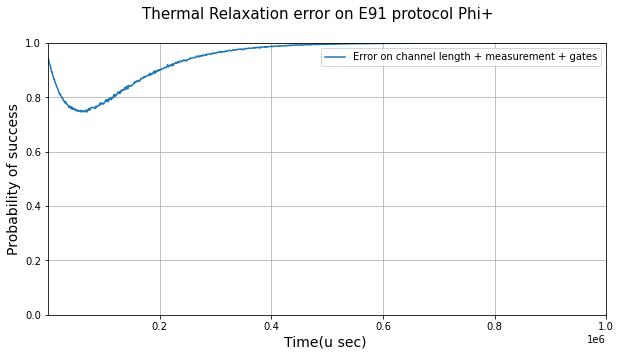

<Figure size 576x360 with 0 Axes>

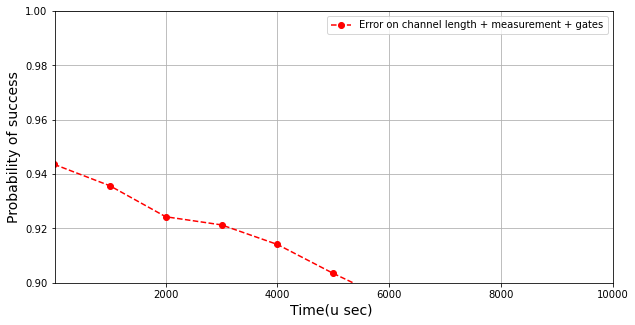

<Figure size 576x360 with 0 Axes>

In [62]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,d,label = "Error on channel length + measurement + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,d,'ro--',label = "Error on channel length + measurement + gates")
ax.legend()

In [63]:
import matplotlib.pyplot as plt

listofSuccess_DMG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DMG.append(success)
    

In [64]:
from statistics import mean
a= listofSuccess_DMG
print(*map(mean, zip(*a)))

0.9409 0.93035 0.9175 0.9073 0.9035500000000001 0.8905000000000001 0.88175 0.87445 0.8629 0.8559 0.8483499999999999 0.83585 0.8249 0.81555 0.8101 0.8019000000000001 0.79285 0.78 0.77085 0.77095 0.75745 0.75315 0.7472 0.73325 0.7258 0.7219 0.7116 0.7067 0.69375 0.69455 0.67795 0.67995 0.66695 0.6585000000000001 0.64735 0.6458 0.6403 0.62895 0.6253 0.62055 0.61425 0.6031 0.60315 0.59725 0.594 0.5852499999999999 0.5755 0.5676 0.56645 0.5532 0.54855 0.54105 0.5359 0.53115 0.5257000000000001 0.52285 0.5187 0.5115500000000001 0.50435 0.49775 0.4985 0.49324999999999997 0.48895 0.48475 0.47675 0.46535 0.4647 0.4602 0.45265 0.45035000000000003 0.4459 0.4371 0.43415 0.43105 0.42014999999999997 0.4263 0.4174 0.41535 0.40765 0.40465 0.40005 0.39815 0.3829 0.39035 0.38155 0.37715 0.3777 0.3663 0.36619999999999997 0.36705 0.3638 0.35605 0.3563 0.34735 0.33835 0.33635 0.34005 0.3318 0.3232 0.33035 0.31515 0.3194 0.31725000000000003 0.31815 0.30274999999999996 0.3015 0.3008 0.2966 0.2957 0.29264999999

In [65]:
d2=[0.9409,0.93035,0.9175,0.9073,0.9035500000000001,0.8905000000000001,0.88175,0.87445,0.8629,0.8559,0.8483499999999999,0.83585,0.8249,0.81555,0.8101,0.8019000000000001,0.79285,0.78,0.77085,0.77095,0.75745,0.75315,0.7472,0.73325,0.7258,0.7219,0.7116,0.7067,0.69375,0.69455,0.67795,0.67995,0.66695,0.6585000000000001,0.64735,0.6458,0.6403,0.62895,0.6253,0.62055,0.61425,0.6031,0.60315,0.59725,0.594,0.5852499999999999,0.5755,0.5676,0.56645,0.5532,0.54855,0.54105,0.5359,0.53115,0.5257000000000001,0.52285,0.5187,0.5115500000000001,0.50435,0.49775,0.4985,0.49324999999999997,0.48895,0.48475,0.47675,0.46535,0.4647,0.4602,0.45265,0.45035000000000003,0.4459,0.4371,0.43415,0.43105,0.42014999999999997,0.4263,0.4174,0.41535,0.40765,0.40465,0.40005,0.39815,0.3829,0.39035,0.38155,0.37715,0.3777,0.3663,0.36619999999999997,0.36705,0.3638,0.35605,0.3563,0.34735,0.33835,0.33635,0.34005,0.3318,0.3232,0.33035,0.31515,0.3194,0.31725000000000003,0.31815,0.30274999999999996,0.3015,0.3008,0.2966,0.2957,0.29264999999999997,0.2879,0.28835,0.2808,0.2823,0.27435,0.27955,0.26715,0.27185000000000004,0.26585000000000003,0.2637,0.2577,0.25735,0.25455,0.2496,0.24905,0.24435,0.2438,0.24265,0.2399,0.2294,0.2322,0.22965,0.232,0.2214,0.2246,0.2185,0.2164,0.2191,0.2124,0.21534999999999999,0.20965,0.2076,0.2066,0.20045,0.2039,0.198,0.1953,0.19795,0.1904,0.18865,0.18575,0.1889,0.1839,0.1833,0.17825,0.18185,0.1776,0.1777,0.17245,0.1742,0.17005,0.16935,0.16915,0.16345,0.1594,0.16725,0.15745,0.1593,0.15259999999999999,0.155,0.15195,0.1513,0.1514,0.14545,0.14275,0.14805,0.1449,0.1462,0.1427,0.1397,0.1367,0.1329,0.1358,0.1327,0.13345,0.13145,0.1282,0.1257,0.12665,0.12165000000000001,0.12315,0.12015,0.121,0.11655,0.1208,0.11435000000000001,0.11645,0.11485,0.1181,0.11385,0.11235,0.10785,0.11265,0.11235,0.10465,0.1035,0.1004,0.1031,0.10095,0.10285,0.0977,0.0959,0.09925,0.09725,0.09405,0.09195,0.09075,0.09295,0.08814999999999999,0.09175,0.08975,0.08905,0.08695,0.08745,0.082,0.084,0.0851,0.0844,0.0821,0.0826,0.07835,0.08035,0.0763,0.07815,0.07505,0.0745,0.07465,0.0743,0.0744,0.0732,0.07375,0.072,0.0667,0.0734,0.0725,0.0685,0.0692,0.06845,0.06305,0.0661,0.0651,0.06545000000000001,0.06275,0.06395,0.06035,0.05905,0.06055,0.0591,0.0584,0.0576,0.05745,0.0579,0.0581,0.0539,0.05575,0.0558,0.05655,0.0541,0.0514,0.0531,0.0541,0.0509,0.0496,0.05305,0.048,0.0502,0.049800000000000004,0.048549999999999996,0.049,0.0445,0.04535,0.048549999999999996,0.0457,0.04485,0.04675,0.0452,0.04335,0.042749999999999996,0.04015,0.0422,0.04075,0.0432,0.04125,0.04175,0.0407,0.0392,0.0397,0.04175,0.0363,0.0394,0.03845,0.03755,0.0348,0.03565,0.03675,0.0326,0.03615,0.03415,0.0332,0.03675,0.0318,0.0338,0.0327,0.0324,0.0335,0.0329,0.0321,0.0327,0.03055,0.033,0.0309,0.0325,0.0299,0.0305,0.0305,0.02645,0.0266,0.02845,0.0262,0.0268,0.0269,0.0286,0.027549999999999998,0.02685,0.02535,0.0253,0.026,0.0252,0.02415,0.02475,0.025,0.0232,0.0226,0.02545,0.02445,0.0226,0.0224,0.02225,0.02445,0.0211,0.02055,0.0219,0.02275,0.02155,0.02005,0.02025,0.0198,0.0211,0.0199,0.02085,0.0184,0.0211,0.01815,0.01765,0.0189,0.0182,0.01925,0.01955,0.0188,0.01905,0.01705,0.01855,0.01885,0.01755,0.01675,0.0165,0.0159,0.0164,0.0177,0.0159,0.01685,0.0166,0.01395,0.01575,0.01435,0.0156,0.0135,0.01565,0.0163,0.01395,0.0153,0.01565,0.0135,0.01415,0.01505,0.01455,0.01485,0.0135,0.01355,0.0133,0.01355,0.013,0.01215,0.0128,0.01265,0.01175,0.011049999999999999,0.0114,0.0124,0.01185,0.0121,0.01185,0.0115,0.01075,0.01235,0.0107,0.01185,0.0124,0.0106,0.01035,0.011099999999999999,0.0106,0.01065,0.00985,0.01075,0.01035,0.0091,0.01045,0.0102,0.00855,0.0088,0.00995,0.00885,0.0097,0.0088,0.00945,0.009049999999999999,0.0077,0.0088,0.00735,0.00865,0.00875,0.00745,0.00835,0.00735,0.00895,0.0082,0.00825,0.0072,0.00905,0.0078,0.00705,0.007,0.0072,0.00685,0.00625,0.0059,0.0088,0.0066,0.0066,0.00695,0.00645,0.00655,0.00705,0.0071,0.00615,0.00615,0.0071,0.00635,0.00685,0.00545,0.0065,0.00555,0.00665,0.00555,0.0069,0.0058000000000000005,0.0049,0.0065,0.0064,0.00525,0.0052,0.00445,0.0056,0.0045,0.00415,0.00515,0.0054,0.00575,0.00495,0.00435,0.00485,0.0057,0.0058000000000000005,0.00475,0.00555,0.00455,0.00535,0.0049,0.0043,0.00435,0.00525,0.00405,0.0043,0.00365,0.0038,0.00385,0.00425,0.0043,0.00395,0.0034000000000000002,0.00455,0.00515,0.0027,0.0039000000000000003,0.00355,0.00335,0.00365,0.00355,0.0035,0.0029000000000000002,0.00335,0.00375,0.00405,0.00305,0.00365,0.0039,0.0034000000000000002,0.0031,0.00355,0.00385,0.0034000000000000002,0.003,0.00295,0.00315,0.0023,0.00265,0.0034000000000000002,0.0024000000000000002,0.0034000000000000002,0.003,0.0034000000000000002,0.0024000000000000002,0.0033,0.0026,0.00315,0.0024000000000000002,0.00245,0.0023,0.00235,0.00315,0.00295,0.0028,0.00275,0.00295,0.00295,0.00265,0.00245,0.0022,0.0026,0.00265,0.0025,0.0022500000000000003,0.002,0.00285,0.0019500000000000001,0.0022500000000000003,0.0019500000000000001,0.0014500000000000001,0.0024000000000000002,0.0022,0.00235,0.002,0.0021,0.0018,0.0017000000000000001,0.00185,0.00185,0.00185,0.0018,0.00185,0.00235,0.00165,0.00165,0.00165,0.00285,0.0022,0.002,0.0015,0.0022,0.0022,0.0017000000000000001,0.00135,0.0022500000000000003,0.0017000000000000001,0.00205,0.0018,0.0017000000000000001,0.0018,0.00175,0.002,0.0014,0.0014,0.00185,0.00115,0.0013,0.001,0.0015,0.00165,0.0015,0.00135,0.0015,0.0017000000000000001,0.0014500000000000001,0.00115,0.0011,0.00125,0.00095,0.00125,0.00095,0.0014500000000000001,0.0011,0.00105,0.0006000000000000001,0.00155,0.00135,0.001,0.001,0.00115,0.0012000000000000001,0.0012000000000000001,0.00095,0.0008500000000000001,0.0011,0.001,0.0008,0.00135,0.0012000000000000001,0.0007,0.0008500000000000001,0.0014500000000000001,0.0013,0.00115,0.00105,0.0011,0.00065,0.00065,0.0009,0.00095,0.00095,0.0008,0.00065,0.00135,0.00095,0.0006000000000000001,0.00065,0.0011,0.00075,0.0009,0.00075,0.00055,0.0006000000000000001,0.001,0.00095,0.00065,0.0005,0.0007,0.0006000000000000001,0.00065,0.0009,0.0004,0.0006000000000000001,0.0002,0.0004,0.00055,0.0007,0.0006000000000000001,0.0006000000000000001,0.0011,0.00075,0.00075,0.00065,0.0006000000000000001,0.0008,0.0007,0.00055,0.0004,0.00065,0.00055,0.00055,0.0007,0.0006000000000000001,0.0006000000000000001,0.00045,0.0006000000000000001,0.00045,0.0009,0.00095,0.0006000000000000001,0.00035,0.00055,0.00055,0.0008500000000000001,0.00055,0.00045,0.00065,0.00095,0.00045,0.00015000000000000001,0.0004,0.00035,0.0004,0.00045,0.0002,0.00045,0.0007,0.00035,0.0006000000000000001,0.00045,0.00045,0.0006000000000000001,0.0006000000000000001,0.0002,0.00030000000000000003,0.00025,0.00025,0.00045,0.00035,0.0004,0.0001,0.00025,0.00015000000000000001,0.00025,0.0004,0.0004,0.0004,0.0005,0.00055,0.00035,0.00045,0.00025,0.0004,0.00025,0.0005,0.00015000000000000001,0.00015000000000000001,0.00045,0.00025,0.0004,0.00015000000000000001,0.00035,0.00025,0.00035,0.00025,0.00035,0.0002,0.00030000000000000003,0.00035,0.00030000000000000003,0.0004,0.00035,0.0004,0.00015000000000000001,0.0004,0.00025,0.0,0.00030000000000000003,0.0002,0.00055,0.0005,0.00030000000000000003,0.00025,0.0002,0.00015000000000000001,0.0002,0.00030000000000000003,0.0002,0.00035,0.00015000000000000001,0.00015000000000000001,0.0002,0.00015000000000000001,0.00015000000000000001,0.0001,0.00015000000000000001,0.00035,0.0002,0.00015000000000000001,0.00025,0.00015000000000000001,5e-05,0.0001,0.00015000000000000001,0.0001,0.00035,0.0002,5e-05,0.0001,0.0002,0.00030000000000000003,5e-05,0.00015000000000000001,5e-05,0.0002,0.0002,0.0001,5e-05,0.00015000000000000001,0.0002,0.0001,0.00025,0.0002,0.0001,0.0001,5e-05,0.0002,0.00015000000000000001,0.00025,0.0001,0.0001,0.0001,5e-05,0.00015000000000000001,5e-05,0.0002,0.00025,0.00015000000000000001,5e-05,0.0001,0.0,0.00015000000000000001,0.00015000000000000001,5e-05,0.0001,5e-05,0.00025,5e-05,0.0001,0.0,0.00015000000000000001,0.0001,0.00025,5e-05,0.0001,0.0,0.0001,0.0001,0.0001,5e-05,0.00025,0.00025,0.0002,0.00015000000000000001,0.00015000000000000001,5e-05,0.0001,5e-05,0.00015000000000000001,5e-05,0.00030000000000000003,0.00015000000000000001,0.0001,5e-05,0.00015000000000000001,0.0,5e-05,0.00015000000000000001,0.0001,5e-05,0.00015000000000000001,5e-05,0.0001,5e-05,0.0001,0.00015000000000000001,5e-05,5e-05,0.0,5e-05,5e-05,5e-05,0.0001,5e-05,5e-05,0.0,5e-05,5e-05,0.0,5e-05,5e-05,0.0,0.00015000000000000001,0.00015000000000000001,5e-05,0.0001,5e-05,0.00015000000000000001,5e-05,5e-05,0.0,0.0001,0.0001,0.0001,5e-05,0.0001,0.0001,5e-05,0.0,0.0001,0.0001,0.0,0.0,0.0001,5e-05,0.0,0.0,5e-05,5e-05,0.0,5e-05,0.0001,5e-05,5e-05,0.0,0.0,0.0,5e-05,0.0,0.0001,0.00015000000000000001,5e-05,5e-05,0.0001,5e-05,0.0,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0001,5e-05,0.0,5e-05,5e-05,0.0,5e-05,0.0001,0.0,5e-05,5e-05,5e-05,5e-05,5e-05,0.0001,0.0,0.0,5e-05,5e-05,5e-05,0.0,0.0,5e-05,0.0,5e-05,0.0,5e-05,5e-05,5e-05,5e-05,0.0,0.0001,5e-05,5e-05,0.0001,0.0,0.0,5e-05,0.0,5e-05,0.0,5e-05,0.00015000000000000001,0.0,0.0,5e-05,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0]


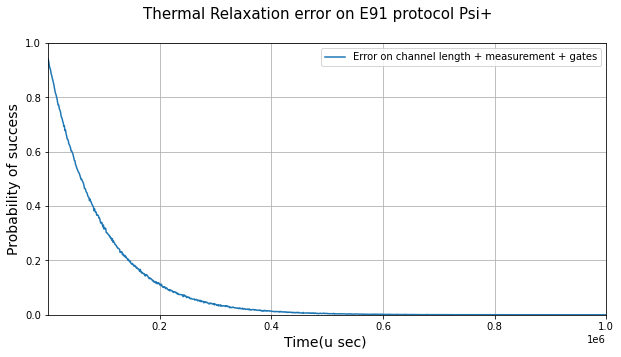

<Figure size 576x360 with 0 Axes>

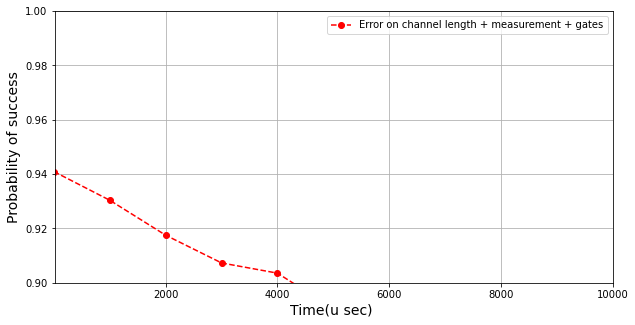

<Figure size 576x360 with 0 Axes>

In [66]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,d2,label = "Error on channel length + measurement + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,d2,'ro--',label = "Error on channel length + measurement + gates")
ax.legend()

# Delay and Gate

In [67]:
import matplotlib.pyplot as plt

listofSuccess_DG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": False, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DG.append(success)
    

In [68]:
from statistics import mean
a= listofSuccess_DG
print(*map(mean, zip(*a)))

0.9975 0.9864999999999999 0.97495 0.96605 0.9573999999999999 0.9493499999999999 0.9389 0.93165 0.9235500000000001 0.91225 0.9036000000000001 0.90015 0.89075 0.88725 0.87975 0.86855 0.86535 0.86065 0.8561 0.8488 0.84305 0.83375 0.82965 0.832 0.8238 0.8227 0.813 0.8165 0.81165 0.8082 0.80435 0.8003 0.7952 0.7913 0.7873 0.78135 0.7816500000000001 0.77915 0.77815 0.7741 0.77045 0.7728 0.77115 0.76215 0.7664 0.7639 0.75645 0.76005 0.7603 0.75475 0.7556 0.7539 0.75145 0.7527 0.7523 0.75625 0.74925 0.7529 0.7476 0.74995 0.75425 0.7527 0.74845 0.74725 0.7533 0.75365 0.74965 0.75325 0.7466 0.7495 0.75075 0.7478 0.7496 0.74855 0.75525 0.75545 0.7524 0.756 0.7572 0.7556 0.75375 0.75775 0.7589 0.76105 0.75575 0.7624 0.7665500000000001 0.7612 0.763 0.76485 0.76265 0.76595 0.76315 0.7718 0.7673 0.7695000000000001 0.76985 0.7685500000000001 0.77525 0.7784 0.779 0.7789 0.7766000000000001 0.7762 0.7761 0.7783 0.7836500000000001 0.784 0.7856000000000001 0.78505 0.7857500000000001 0.79215 0.7902 0.79135 

In [69]:
e=[0.9975,0.9864999999999999,0.97495,0.96605,0.9573999999999999,0.9493499999999999,0.9389,0.93165,0.9235500000000001,0.91225,0.9036000000000001,0.90015,0.89075,0.88725,0.87975,0.86855,0.86535,0.86065,0.8561,0.8488,0.84305,0.83375,0.82965,0.832,0.8238,0.8227,0.813,0.8165,0.81165,0.8082,0.80435,0.8003,0.7952,0.7913,0.7873,0.78135,0.7816500000000001,0.77915,0.77815,0.7741,0.77045,0.7728,0.77115,0.76215,0.7664,0.7639,0.75645,0.76005,0.7603,0.75475,0.7556,0.7539,0.75145,0.7527,0.7523,0.75625,0.74925,0.7529,0.7476,0.74995,0.75425,0.7527,0.74845,0.74725,0.7533,0.75365,0.74965,0.75325,0.7466,0.7495,0.75075,0.7478,0.7496,0.74855,0.75525,0.75545,0.7524,0.756,0.7572,0.7556,0.75375,0.75775,0.7589,0.76105,0.75575,0.7624,0.7665500000000001,0.7612,0.763,0.76485,0.76265,0.76595,0.76315,0.7718,0.7673,0.7695000000000001,0.76985,0.7685500000000001,0.77525,0.7784,0.779,0.7789,0.7766000000000001,0.7762,0.7761,0.7783,0.7836500000000001,0.784,0.7856000000000001,0.78505,0.7857500000000001,0.79215,0.7902,0.79135,0.7946500000000001,0.79125,0.7907500000000001,0.7992,0.79305,0.80215,0.7935,0.7996,0.8048500000000001,0.8038500000000001,0.80735,0.80805,0.80645,0.80775,0.81045,0.8134,0.8120499999999999,0.81565,0.8196,0.8171999999999999,0.81995,0.8196,0.8214,0.82305,0.8222,0.8235,0.82685,0.82495,0.8334999999999999,0.82805,0.8336,0.83595,0.838,0.83485,0.8416,0.8372499999999999,0.83915,0.8457,0.8428,0.8454499999999999,0.8462,0.84485,0.84075,0.84715,0.84465,0.8533,0.8487,0.85565,0.8563,0.8591,0.86205,0.8597,0.8593999999999999,0.8654,0.8643,0.8627,0.8684499999999999,0.8664,0.86715,0.86225,0.86895,0.8729,0.87765,0.87265,0.87435,0.87585,0.8754,0.8799,0.8817,0.8774,0.8779,0.8792,0.8841,0.8827,0.88465,0.8827,0.88715,0.8872,0.88605,0.88695,0.8942,0.894,0.89195,0.89435,0.8919,0.89535,0.8933,0.89805,0.90045,0.8977,0.89985,0.8978,0.90085,0.9003,0.90385,0.9044,0.90805,0.90515,0.9108,0.90715,0.9094,0.91125,0.9115500000000001,0.9138000000000001,0.9121,0.9126500000000001,0.91405,0.91845,0.9171,0.9217000000000001,0.9175,0.9176000000000001,0.9225500000000001,0.9225000000000001,0.9209,0.92125,0.9253,0.9239,0.9235,0.9226000000000001,0.92495,0.92535,0.92845,0.92825,0.92845,0.92835,0.9331,0.92925,0.93175,0.93115,0.93205,0.93215,0.93285,0.9345,0.9319500000000001,0.9368,0.93635,0.93555,0.93865,0.93985,0.9384,0.9422,0.93775,0.93875,0.9405,0.94295,0.9420499999999999,0.94345,0.94405,0.94395,0.944,0.9483499999999999,0.9451999999999999,0.94755,0.9459,0.9475,0.9482499999999999,0.9474,0.94655,0.95155,0.9452499999999999,0.9512999999999999,0.9535,0.94975,0.9505,0.9534499999999999,0.95305,0.95065,0.95465,0.95295,0.9566,0.9595,0.9532999999999999,0.95485,0.9593499999999999,0.95555,0.95695,0.9573999999999999,0.9592499999999999,0.9582499999999999,0.95875,0.9613499999999999,0.9591,0.9591999999999999,0.96215,0.962,0.9621999999999999,0.96305,0.9623999999999999,0.9628,0.9636,0.9632,0.96555,0.9642499999999999,0.9652499999999999,0.9662999999999999,0.9655,0.96615,0.9663499999999999,0.9672499999999999,0.9641,0.96705,0.9638,0.9672,0.9687,0.96925,0.9687,0.9681,0.96965,0.96855,0.96875,0.969,0.97005,0.97215,0.9713499999999999,0.9702999999999999,0.97195,0.97195,0.97075,0.97155,0.9733499999999999,0.9732,0.9724999999999999,0.9759,0.97195,0.97365,0.9764499999999999,0.9755,0.97475,0.97565,0.97515,0.9764999999999999,0.97665,0.97515,0.9749,0.9773499999999999,0.9781,0.97715,0.9779,0.97695,0.9776,0.9764999999999999,0.97765,0.9783999999999999,0.9776,0.9803,0.97805,0.97995,0.9808,0.97825,0.9801,0.98105,0.98125,0.98155,0.98205,0.9822,0.98255,0.981,0.9812,0.9808,0.9817,0.98275,0.9829,0.9831,0.98335,0.9821,0.9842,0.9833999999999999,0.98375,0.9847,0.9836,0.98275,0.98465,0.984,0.9857,0.98365,0.9854499999999999,0.9853,0.98685,0.98515,0.98565,0.9861,0.98565,0.9869,0.9856,0.98535,0.9873,0.9863,0.9859,0.98735,0.98675,0.9871,0.9864999999999999,0.98835,0.9884499999999999,0.9876,0.98815,0.9884499999999999,0.989,0.98855,0.98885,0.98775,0.988,0.9891,0.99,0.98915,0.98835,0.98925,0.98905,0.98995,0.9894499999999999,0.9902,0.9899,0.98995,0.9884499999999999,0.9903,0.9906,0.9898,0.991,0.9915,0.99105,0.9904999999999999,0.99035,0.9903,0.9907,0.9895,0.99125,0.9896,0.9911,0.9918,0.99105,0.99095,0.9922,0.99075,0.99235,0.9923,0.993,0.99325,0.99275,0.9923,0.9923,0.99205,0.99275,0.9926,0.99285,0.9928,0.9919,0.993,0.9926,0.9935,0.994,0.99225,0.9935,0.99405,0.9939,0.99235,0.993,0.99335,0.9937,0.99435,0.9939,0.99545,0.99375,0.9944,0.9944999999999999,0.99295,0.99465,0.99485,0.9941,0.9942,0.99425,0.99385,0.9949,0.99515,0.9952,0.99505,0.9946,0.99525,0.9947,0.9954,0.99485,0.9956,0.99585,0.99595,0.99515,0.9944999999999999,0.99515,0.99545,0.9951,0.99575,0.99615,0.9947,0.99525,0.9957,0.99605,0.99515,0.99635,0.9957,0.99625,0.9963,0.99585,0.9958,0.996,0.99615,0.99505,0.997,0.9964999999999999,0.99625,0.99685,0.996,0.99495,0.9964,0.99655,0.99695,0.9964999999999999,0.99665,0.9958,0.9964999999999999,0.9975,0.9971,0.99695,0.99685,0.9974,0.9966,0.9962,0.99685,0.99685,0.99645,0.9966,0.9964999999999999,0.9966,0.9976,0.99675,0.9966,0.99685,0.99705,0.9973,0.99715,0.9981,0.9976,0.99785,0.9976,0.99725,0.99705,0.9973,0.99725,0.99795,0.99775,0.9977,0.9971,0.9978,0.99735,0.9977,0.99755,0.9976,0.998,0.99755,0.9981,0.99805,0.99775,0.99765,0.9982,0.99775,0.99805,0.99805,0.9983,0.9984999999999999,0.99825,0.99835,0.99815,0.9984,0.99805,0.998,0.998,0.99825,0.9984999999999999,0.99885,0.9979,0.99785,0.998,0.99765,0.99835,0.99785,0.99835,0.99845,0.99785,0.9987,0.99865,0.9982,0.9984,0.9983,0.9987,0.9983,0.99865,0.99845,0.9981,0.99835,0.9988,0.9983,0.9984,0.99855,0.9986,0.9989,0.99825,0.9988,0.99865,0.99865,0.99895,0.9988,0.99865,0.99875,0.9991,0.9988,0.9987,0.9986,0.99875,0.99875,0.99835,0.9991,0.9988,0.99855,0.9989,0.99885,0.9991,0.99915,0.9992,0.99875,0.99915,0.9992,0.9991,0.99925,0.99915,0.9992,0.9993,0.9988,0.99935,0.9987,0.9989,0.99945,0.9993,0.9991,0.99925,0.9991,0.999,0.9993,0.99915,0.9992,0.9987,0.999,0.99925,0.9993,0.9996,0.99945,0.9994,0.9993,0.9991,0.99935,0.99925,0.99925,0.99915,0.99915,0.99935,0.9993,0.99935,0.99945,0.99895,0.99945,0.99925,0.9993,0.99905,0.9992,0.99955,0.9997,0.99925,0.99925,0.99925,0.9996,0.9992,0.9992,0.9991,0.99975,0.99935,0.99935,0.9997,0.99965,0.9997,0.9992,0.99935,0.9994,0.9997,0.9997,0.9992,0.9993,0.9997,0.99955,0.9994,0.99965,0.9997,0.9996,0.9997,0.99965,0.9995,0.99955,0.9996,0.9995,0.9996,0.99935,0.9995,0.99945,0.99935,0.99975,0.9997,0.99965,0.99965,0.99945,0.99955,0.99945,0.9996,0.99965,0.9996,0.9995,0.99955,0.9994,0.9995,0.99975,0.9999,0.99965,0.9994,0.9996,0.9996,0.99965,0.9996,0.99955,0.9998,0.99975,0.9996,0.99975,0.99965,0.9996,0.99975,0.99965,0.99945,0.9998,0.9997,0.99975,0.9997,0.99965,0.9997,0.99965,0.9996,0.99965,0.99965,0.99955,0.9996,0.99985,0.99985,0.99975,0.99985,0.9997,0.9996,0.99975,0.99965,0.99985,0.9996,0.99965,0.99975,0.99995,0.99985,0.9999,0.99985,0.9998,0.99985,0.9998,0.9998,0.9995,0.9999,0.9998,0.99985,0.99975,0.9999,0.9997,0.99975,0.9998,0.99965,0.99995,0.99975,0.9998,0.99995,0.9998,0.9998,0.99985,0.9996,0.9999,0.99985,0.9999,0.9998,0.99985,1.0,0.99985,0.99995,0.9998,0.9998,0.9997,0.9998,0.9998,0.99985,0.99995,0.9999,0.9999,0.99985,0.99985,0.9999,0.99985,0.99985,0.9997,0.99985,0.99965,0.9997,0.99985,0.9999,1.0,0.99985,0.99975,0.9997,1.0,0.99995,0.99995,0.99975,0.9998,0.9999,0.99985,0.9999,0.99975,0.9999,0.9998,1.0,0.99985,0.9999,0.99985,0.9999,0.9999,0.9999,0.9999,0.99975,0.9999,0.9998,0.99995,0.9999,0.99975,0.9999,0.99985,0.99995,1.0,0.99985,0.99985,0.99985,0.99995,0.9999,0.9999,0.99995,0.9999,0.9999,0.9999,0.99995,0.99995,0.99985,0.9999,0.99995,0.99995,1.0,0.99995,0.99995,0.99995,0.99985,1.0,1.0,0.9999,0.9998,0.99995,0.9999,0.9999,0.99995,0.99995,0.99985,0.99985,1.0,1.0,0.9999,0.99995,1.0,1.0,0.9999,1.0,0.9999,0.99995,0.99995,0.99995,0.99975,0.99985,0.99995,1.0,1.0,0.9999,0.99995,0.9999,0.9999,0.9999,0.99995,0.99995,1.0,1.0,1.0,1.0,0.99995,1.0,0.99985,1.0,0.99995,1.0,0.99995,1.0,0.9999,0.99995,0.99995,1.0,0.9999,0.9999,1.0,0.99985,0.99995,1.0,0.99985,0.99995,1.0,0.99995,1.0,1.0,0.99995,0.9999,1.0,0.99995,1.0,0.99995,1.0,0.99995,0.99985,1.0,0.99995,1.0,1.0,1.0,0.99995,1.0,0.99995,1.0,0.99995,1.0,1.0,1.0,1.0,0.99995,0.99995,0.9999,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,0.9999,1.0,0.99995,1.0,0.9999,1.0,1.0,0.99995,1.0,1.0,1.0,0.99995,0.99995,0.99995,1.0,1.0,1.0]


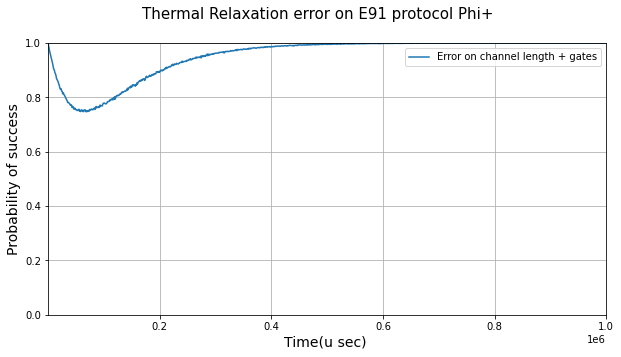

<Figure size 576x360 with 0 Axes>

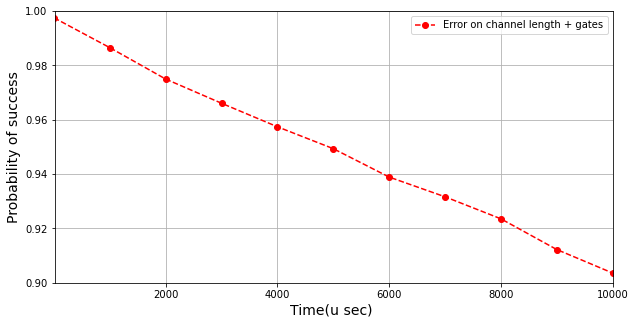

<Figure size 576x360 with 0 Axes>

In [70]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,e,label = "Error on channel length + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,e,'ro--',label = "Error on channel length + gates")
ax.legend()

In [71]:
import matplotlib.pyplot as plt

listofSuccess_DG=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": False, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    #print(success) Enable it to see the reading
    listofSuccess_DG.append(success)
    

In [72]:
from statistics import mean
a= listofSuccess_DG
print(*map(mean, zip(*a)))

0.99625 0.9863999999999999 0.9755 0.9627 0.9547 0.94605 0.93865 0.9238500000000001 0.9151 0.9045000000000001 0.89675 0.88725 0.8788 0.8654499999999999 0.8589 0.8505 0.8412 0.83295 0.8175 0.8174 0.8062 0.7981 0.78835 0.7847500000000001 0.77195 0.76975 0.74975 0.7513 0.73575 0.73075 0.7176 0.7146 0.7007 0.70375 0.69685 0.6854 0.6785 0.6738000000000001 0.6625000000000001 0.6556000000000001 0.6518 0.64165 0.6361 0.625 0.6186 0.6156 0.6078 0.6016 0.5912499999999999 0.5918 0.5841 0.577 0.5714 0.5666 0.5575 0.5481 0.54405 0.54615 0.53105 0.5276000000000001 0.5234 0.51805 0.51605 0.5039 0.50045 0.49995 0.4909 0.4859 0.48314999999999997 0.47565 0.4725 0.4624 0.4583 0.44655 0.4598 0.4444 0.44395 0.439 0.4292 0.42885 0.4309 0.41675 0.4179 0.41345 0.40905 0.40325 0.3961 0.39490000000000003 0.3903 0.3887 0.3782 0.38435 0.3763 0.3645 0.36895 0.3559 0.3571 0.361 0.35135 0.3548 0.3433 0.34255 0.32695 0.329 0.32535000000000003 0.3268 0.3153 0.315 0.3178 0.31675 0.30405 0.30365 0.3035 0.2943 0.2969 0.29

In [73]:
e2=[0.99625,0.9863999999999999,0.9755,0.9627,0.9547,0.94605,0.93865,0.9238500000000001,0.9151,0.9045000000000001,0.89675,0.88725,0.8788,0.8654499999999999,0.8589,0.8505,0.8412,0.83295,0.8175,0.8174,0.8062,0.7981,0.78835,0.7847500000000001,0.77195,0.76975,0.74975,0.7513,0.73575,0.73075,0.7176,0.7146,0.7007,0.70375,0.69685,0.6854,0.6785,0.6738000000000001,0.6625000000000001,0.6556000000000001,0.6518,0.64165,0.6361,0.625,0.6186,0.6156,0.6078,0.6016,0.5912499999999999,0.5918,0.5841,0.577,0.5714,0.5666,0.5575,0.5481,0.54405,0.54615,0.53105,0.5276000000000001,0.5234,0.51805,0.51605,0.5039,0.50045,0.49995,0.4909,0.4859,0.48314999999999997,0.47565,0.4725,0.4624,0.4583,0.44655,0.4598,0.4444,0.44395,0.439,0.4292,0.42885,0.4309,0.41675,0.4179,0.41345,0.40905,0.40325,0.3961,0.39490000000000003,0.3903,0.3887,0.3782,0.38435,0.3763,0.3645,0.36895,0.3559,0.3571,0.361,0.35135,0.3548,0.3433,0.34255,0.32695,0.329,0.32535000000000003,0.3268,0.3153,0.315,0.3178,0.31675,0.30405,0.30365,0.3035,0.2943,0.2969,0.29109999999999997,0.28745,0.28805,0.2829,0.279,0.27975,0.2727,0.27005,0.2703,0.26265,0.2667,0.2589,0.25425,0.2559,0.25195,0.2481,0.2452,0.24230000000000002,0.23935,0.2431,0.23185,0.23455,0.22585,0.22815,0.2233,0.2215,0.2185,0.21965,0.2157,0.2143,0.21509999999999999,0.209,0.2075,0.2048,0.20350000000000001,0.19874999999999998,0.20075,0.19755,0.19085,0.19045,0.18505,0.18705,0.18515,0.17925,0.1814,0.18055,0.17725,0.1735,0.17435,0.1736,0.16915,0.16715,0.1692,0.16955,0.1664,0.1624,0.1562,0.1613,0.156,0.15515,0.1538,0.14955,0.1487,0.1472,0.1461,0.1428,0.14235,0.14455,0.13935,0.14095,0.1372,0.1399,0.13655,0.13295,0.13475,0.1303,0.12865000000000001,0.1255,0.1247,0.1217,0.12205,0.11885,0.1194,0.11625,0.1184,0.11595,0.11305,0.11765,0.11535000000000001,0.11475,0.11055,0.1109,0.1073,0.108,0.10655,0.1033,0.10115,0.10414999999999999,0.10065,0.1049,0.0997,0.09965,0.1011,0.0973,0.09575,0.0939,0.09175,0.0927,0.0941,0.09179999999999999,0.0864,0.08455,0.08795,0.0849,0.08235,0.086,0.0834,0.0823,0.08245,0.08135,0.0827,0.07875,0.0806,0.0797,0.07685,0.07695,0.0708,0.07225,0.0699,0.07145,0.0749,0.07195,0.07085,0.07175,0.0673,0.06715,0.07025,0.067,0.0688,0.0651,0.0632,0.0661,0.0639,0.06245,0.06195,0.06355,0.06175,0.0608,0.05955,0.0583,0.05985,0.05695,0.0575,0.0574,0.0588,0.05455,0.0555,0.05305,0.05385,0.05365,0.0526,0.050749999999999997,0.05005,0.04875,0.05035,0.05075,0.049,0.04705,0.049049999999999996,0.05135,0.0454,0.04705,0.0463,0.04545,0.0496,0.04565,0.04135,0.0433,0.0411,0.0405,0.04245,0.0424,0.04005,0.04115,0.04225,0.0411,0.04045,0.0374,0.0405,0.0391,0.0373,0.03595,0.0383,0.03835,0.0356,0.0374,0.03435,0.0342,0.03655,0.03475,0.0345,0.03555,0.0328,0.03645,0.0308,0.0311,0.03205,0.0319,0.030100000000000002,0.03385,0.0302,0.0298,0.03125,0.03005,0.02915,0.0294,0.03,0.02605,0.02805,0.0279,0.02635,0.0272,0.0263,0.0265,0.027200000000000002,0.0263,0.0282,0.0252,0.0251,0.023799999999999998,0.02385,0.0216,0.02455,0.02255,0.0228,0.02325,0.02355,0.02565,0.02175,0.02465,0.02215,0.02135,0.0228,0.0229,0.020900000000000002,0.02255,0.01945,0.0212,0.0202,0.01945,0.01955,0.0201,0.01985,0.01875,0.01995,0.01955,0.0199,0.01775,0.01815,0.01745,0.01905,0.0177,0.01635,0.01685,0.01705,0.01805,0.0183,0.0183,0.0152,0.0169,0.017,0.0166,0.0153,0.01555,0.01445,0.0144,0.0158,0.0143,0.01385,0.0149,0.0154,0.0129,0.0141,0.0143,0.01355,0.0135,0.0126,0.0135,0.0138,0.0128,0.0141,0.0138,0.01235,0.0115,0.011899999999999999,0.01115,0.01335,0.01315,0.0129,0.01065,0.0117,0.01,0.01195,0.0119,0.01085,0.01215,0.0104,0.01,0.01025,0.0096,0.01075,0.0105,0.00925,0.011,0.01015,0.0104,0.01025,0.0113,0.01045,0.00945,0.00885,0.0091,0.00895,0.0091,0.0098,0.00865,0.00965,0.0084,0.0091,0.00845,0.00795,0.0074,0.00855,0.0072,0.00775,0.0065,0.0084,0.00865,0.0076,0.00825,0.00775,0.00715,0.0071,0.00745,0.00755,0.00675,0.0068,0.00725,0.0069,0.00735,0.007,0.00705,0.0059,0.0061,0.00645,0.0068,0.0062,0.00625,0.00505,0.00635,0.0066,0.0068000000000000005,0.0061,0.00695,0.0056,0.00635,0.00515,0.00555,0.00585,0.0056,0.0055,0.0056,0.0051,0.004,0.00555,0.00495,0.00465,0.0049,0.0062,0.0053,0.005,0.0038,0.00505,0.00435,0.0043,0.00525,0.00465,0.0037,0.00485,0.00425,0.00485,0.00385,0.00395,0.00435,0.0041,0.00415,0.0051,0.00375,0.00365,0.0045000000000000005,0.0031,0.00375,0.00385,0.0042,0.00355,0.00335,0.00295,0.00375,0.00375,0.00425,0.0033,0.0034000000000000002,0.0033,0.0035,0.00305,0.0032,0.0026,0.0033,0.0035,0.0037,0.0035,0.00305,0.00335,0.00275,0.0028,0.00255,0.0022,0.00315,0.0031,0.0032,0.00315,0.0039000000000000003,0.0026,0.0037,0.00175,0.0024000000000000002,0.00245,0.00295,0.0028,0.0025,0.00255,0.00175,0.00245,0.0025,0.00275,0.00255,0.00295,0.0021,0.0027,0.0026,0.00245,0.0019500000000000001,0.00215,0.00175,0.00265,0.0027,0.0022,0.0019500000000000001,0.0014500000000000001,0.00235,0.0023,0.0017000000000000001,0.00215,0.00175,0.0019500000000000001,0.0024000000000000002,0.00305,0.0022500000000000003,0.00235,0.0016,0.00165,0.0021,0.0017000000000000001,0.00205,0.00185,0.0015,0.00185,0.0019500000000000001,0.00135,0.00155,0.00205,0.0014500000000000001,0.0017000000000000001,0.0016,0.00165,0.0013,0.00175,0.0014500000000000001,0.0014,0.0013,0.00185,0.00135,0.0015,0.00135,0.00155,0.00135,0.0011,0.00105,0.0012000000000000001,0.00185,0.00135,0.00095,0.0011,0.0017000000000000001,0.00105,0.0013,0.00135,0.00125,0.0008500000000000001,0.00135,0.0018,0.00135,0.0017000000000000001,0.0009,0.0014500000000000001,0.00125,0.0011,0.00125,0.00075,0.00135,0.0008,0.0014,0.00075,0.00135,0.00115,0.0008,0.00125,0.00135,0.00075,0.00075,0.00155,0.00115,0.00135,0.0009,0.00105,0.00065,0.0008,0.0011,0.0009,0.0008,0.0014500000000000001,0.0008500000000000001,0.0011,0.0008500000000000001,0.00125,0.0007,0.0008,0.0006000000000000001,0.00065,0.0008,0.0005,0.0008500000000000001,0.0008,0.00095,0.0004,0.00115,0.0008500000000000001,0.00115,0.0008500000000000001,0.0008,0.00075,0.0009,0.0008,0.00065,0.0007,0.0006000000000000001,0.00075,0.00065,0.0008500000000000001,0.0008500000000000001,0.00055,0.00095,0.0009,0.0005,0.00045,0.00065,0.00055,0.00035,0.0006000000000000001,0.00030000000000000003,0.00055,0.0009,0.00065,0.00055,0.00045,0.0005,0.00045,0.00055,0.0005,0.0006000000000000001,0.0008,0.00045,0.0005,0.0007,0.0006000000000000001,0.0005,0.0004,0.00035,0.00045,0.00035,0.0004,0.0002,0.00065,0.00035,0.00035,0.00030000000000000003,0.0002,0.00045,0.0002,0.0004,0.0004,0.001,0.0005,0.00030000000000000003,0.00055,0.0005,0.00030000000000000003,0.0002,0.00015000000000000001,0.00045,0.0004,0.0002,0.00055,0.0004,0.00055,0.0004,0.0002,0.00035,0.00030000000000000003,0.0004,0.00025,0.00030000000000000003,0.00015000000000000001,0.00025,0.00025,0.00015000000000000001,0.0002,0.00035,0.00030000000000000003,0.00030000000000000003,0.00025,5e-05,0.0002,0.00015000000000000001,0.0005,0.00015000000000000001,0.00015000000000000001,0.00030000000000000003,0.00045,0.0001,0.00025,0.00025,0.00025,0.00015000000000000001,0.0002,0.00025,0.0001,0.00035,0.00045,0.00035,0.0002,0.00025,0.00030000000000000003,0.00025,0.0002,0.0005,0.00015000000000000001,0.0002,0.00025,0.00035,5e-05,0.0002,0.00030000000000000003,0.00015000000000000001,5e-05,0.0002,0.0004,0.00030000000000000003,0.00035,0.00030000000000000003,0.00015000000000000001,0.0001,0.00035,5e-05,0.00015000000000000001,0.00015000000000000001,0.00025,0.00015000000000000001,0.0001,0.00015000000000000001,0.0001,0.0002,0.00015000000000000001,0.00025,0.00015000000000000001,0.0001,0.0001,0.0002,0.0,0.0001,0.00015000000000000001,0.00035,0.0001,0.0002,0.0,0.0002,0.0002,5e-05,0.0002,0.00015000000000000001,0.0001,0.0,0.0001,5e-05,5e-05,0.0,0.0001,0.00025,0.00015000000000000001,5e-05,0.00015000000000000001,0.0001,0.0001,0.00015000000000000001,0.0001,0.00015000000000000001,0.0002,0.0002,0.0001,0.0001,0.0002,0.0002,0.0001,0.0001,0.0001,5e-05,0.00015000000000000001,0.0002,0.0,0.0,0.0001,0.00015000000000000001,0.00025,0.00030000000000000003,0.0001,0.0001,0.0002,0.0001,0.0,0.00015000000000000001,5e-05,0.00015000000000000001,0.0,0.0,0.0001,0.00015000000000000001,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.0002,0.0,5e-05,5e-05,0.0,0.0001,0.0002,5e-05,5e-05,5e-05,0.0001,0.0001,5e-05,5e-05,0.0,0.0,5e-05,0.00015000000000000001,5e-05,5e-05,5e-05,0.0,0.0,0.00015000000000000001,0.0001,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0001,0.0001,0.0002,0.00015000000000000001,0.0001,0.0,0.0,0.0,0.0,0.0001,0.00015000000000000001,0.0002,0.0,5e-05,5e-05,0.0001,0.0,5e-05,5e-05,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0,0.0001,0.0,0.0,5e-05,5e-05,0.0,0.0,0.0,0.0,0.0001,5e-05,5e-05,0.0,0.0,5e-05,5e-05,5e-05,5e-05,5e-05,5e-05,0.0001,0.0001,5e-05,0.0,0.00015000000000000001,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,5e-05,0.0,5e-05,0.0,5e-05,5e-05,5e-05,5e-05,0.0,0.0,5e-05,5e-05,5e-05,0.0001,0.0001,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0]


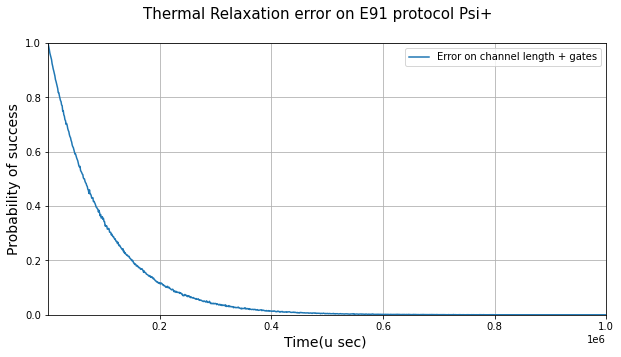

<Figure size 576x360 with 0 Axes>

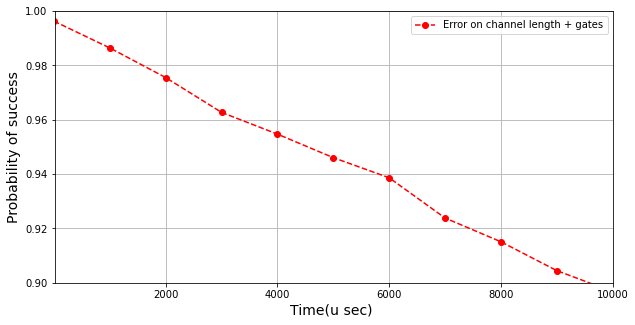

<Figure size 576x360 with 0 Axes>

In [74]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,e2,label = "Error on channel length + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,e2,'ro--',label = "Error on channel length + gates")
ax.legend()

# Graph Compairing

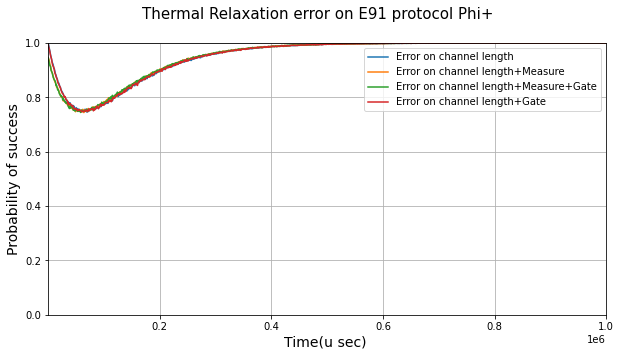

<Figure size 576x360 with 0 Axes>

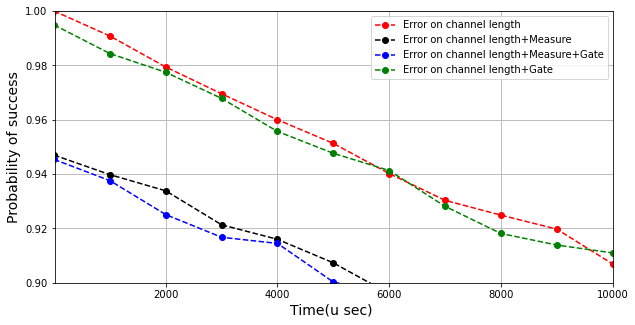

<Figure size 576x360 with 0 Axes>

In [23]:
x1=b
x2=c
x3=d
x4=e
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,label = "Error on channel length")
ax.plot(delay,x2,label = "Error on channel length+Measure")
ax.plot(delay,x3,label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,label = "Error on channel length+Gate")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,x1,'ro--',label = "Error on channel length")
ax.plot(delay,x2,'ko--',label = "Error on channel length+Measure")
ax.plot(delay,x3,'bo--',label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,'go--',label = "Error on channel length+Gate")
ax.legend()
#################################################################################




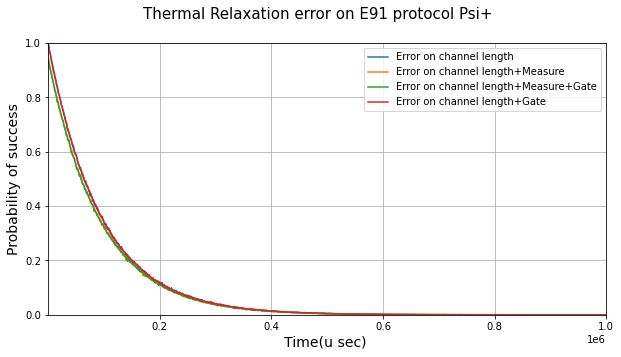

<Figure size 576x360 with 0 Axes>

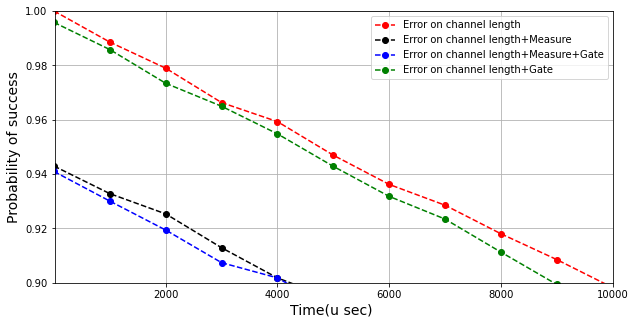

<Figure size 576x360 with 0 Axes>

In [24]:
x1=b2
x2=c2
x3=d2
x4=e2
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,label = "Error on channel length")
ax.plot(delay,x2,label = "Error on channel length+Measure")
ax.plot(delay,x3,label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,label = "Error on channel length+Gate")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,x1,'ro--',label = "Error on channel length")
ax.plot(delay,x2,'ko--',label = "Error on channel length+Measure")
ax.plot(delay,x3,'bo--',label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,'go--',label = "Error on channel length+Gate")
ax.legend()
#################################################################################

